# Prerequsites

In [1]:
# log the time of the experiment
from datetime import datetime
import time

exp_time = datetime.now()
exp_time_str = exp_time.strftime("_%H_%M_%S")
date_str = exp_time.strftime("%m_%d_%y")

In [2]:
# Path management for MacOS and Windows
from pathlib import Path
import os, sys

scriptPath = Path(sys.path[0])
parentPath = Path(sys.path[0]).parent
#libPath = Path("/home/tw329/GitHub/ONN_MNIST/")
libPath = Path("C:\\Users\\Logan\\Documents\\GitHub\\ONN_MNIST")
sys.path.append(libPath.as_posix())
sys.path.append("C:\\Users\\Logan\\Documents\\GitHub\\mcmahon_lab_devices") 

# Set the working directory (to save the files)
resultPath = scriptPath

slmWeightPath = resultPath / "slm_weights"
if not os.path.exists(slmWeightPath.as_posix()):
    os.makedirs(slmWeightPath.as_posix())
    
phoneImagePath = resultPath / "phone_images"
if not os.path.exists(phoneImagePath.as_posix()):
    os.makedirs(phoneImagePath.as_posix())
    
saveDataPath = resultPath / "saved_data"
if not os.path.exists(saveDataPath.as_posix()):
    os.makedirs(saveDataPath.as_posix())
    
print(resultPath)

D:\McMahon lab Dropbox\peter mcmahon\tw329\Experiments\12_01_20_4bit_randy_aug_MLP_100_100_MPPC


In [3]:
from __future__ import print_function
import os, sys
import argparse
from IPython.core.debugger import set_trace
import matplotlib.pyplot as plt
from PIL import Image

import numpy as np
import pandas

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [4]:
%matplotlib notebook

# Instrument Controls

In [5]:
# Configure the SLM
from src.slmpy import SLMdisplay   # Popoff's simple package for controlling SLM

slm = SLMdisplay(isImageLock = True)

LUT_used="AmpLUT_basedon_100120slmbackcali_140509_start5.lut"

slmParamFile = resultPath / ''.join(["slm_info", exp_time_str, ".txt"])
with open(slmParamFile,'w') as slmparams:
    slmparams.write('LUT\t\t\t{}\n'.format(LUT_used))
slmparams.close()


C:/Users/Logan/Documents/GitHub/ONN_MNIST\src\slmpy.py:39: wxPyDeprecationWarning: Call to deprecated item EmptyImage. Use :class:`Image` instead.
  self.img = wx.EmptyImage(2,2)


In [6]:
import pyvisa
from devices import Agilent54845A as AgilentOscope

rm = pyvisa.ResourceManager("C:\\WINDOWS\\System32\\visa64.dll")
gpib_id = rm.list_resources()[-1]
oscope = AgilentOscope(rm.open_resource(gpib_id))
oscope.set_waveform_source(1)

def oscope_info(oscope):
    measure_state = {}
    measure_state["ID"] = oscope.id()
    measure_state["x_range"] = oscope.get_xrange()
    measure_state["x_unit"] = oscope.get_xunits()
    measure_state["y_range"] = oscope.get_yrange()
    measure_state["y_unit"] = oscope.get_yunits()
    measure_state["y_offset"] = oscope.get_offset()
    measure_state["y_bounds"] = [oscope.get_bottom_bound(), oscope.get_top_bound()]
    return measure_state

In [7]:
# Configure the phone

from Android_Display_Control.Remote_Display.image_stream import AndroidOpenAccessoryBridge as AOAB

PIXEL_VENDOR_ID = 0x18d1
PIXEL_UNCONFIG_ID =  0x4ee7
PIXEL_CONFIG_ID = 0x2d01

# Create an AOAB object for managing data send/receive via USB
aoab = AOAB(PIXEL_VENDOR_ID, PIXEL_UNCONFIG_ID, 
  PIXEL_CONFIG_ID,
  manufacturer='ImageStreamManufacturer',
  model='ImageStream1',
  description='Stream Images to Android',
  version=1,
  uri=('https://github.com/chris-blay/android-open-accessory-bridge'),
  serial='AoabSerial')

Exception ignored in: <function _AutoFinalizedObjectBase.__del__ at 0x00000274F01F4C80>
Traceback (most recent call last):
  File "C:\Users\Logan\Anaconda3\lib\site-packages\usb\_objfinalizer.py", line 84, in __del__
    self.finalize()
  File "C:\Users\Logan\Anaconda3\lib\site-packages\usb\_objfinalizer.py", line 144, in finalize
    self._finalizer()
  File "C:\Users\Logan\Anaconda3\lib\weakref.py", line 552, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
  File "C:\Users\Logan\Anaconda3\lib\site-packages\usb\_objfinalizer.py", line 104, in _do_finalize_object_ref
    obj._do_finalize_object()
  File "C:\Users\Logan\Anaconda3\lib\site-packages\usb\_objfinalizer.py", line 71, in _do_finalize_object
    self._finalize_object()
  File "C:\Users\Logan\Anaconda3\lib\site-packages\usb\backend\libusb1.py", line 604, in _finalize_object
    _lib.libusb_unref_device(self.devid)
OSError: exception: access violation writing 0x0000000000000024


In [8]:
def PIL_to_bytestream(img_px):
    array_px = np.array(img_px)
    byte_array_px = bytearray()

    for i in range(array_px.shape[0]):
        for j in range(array_px.shape[1]):
            byte_array_px.append(array_px[i, j, 0])
            byte_array_px.append(array_px[i, j, 1])
            byte_array_px.append(array_px[i, j, 2])

    assert(len(byte_array_px) == 1920*1080*3)
    return byte_array_px

In [9]:
# Load the phone pixel LUT
lut_p = torch.zeros(1000, dtype=torch.uint8) 
with open((resultPath/'PhoneLUT_100120_161444c30et20ms_1000.lut').as_posix(),'r') as lutfile:
        for i in range(len(lut_p)):
            aline = lutfile.readline().split()
            lut_p[i] = int(aline[1])
lutfile.close()

# Helper Functions

In [10]:
""" Helper functions for generating phone and SLM patterns. """

from math import sqrt

def Wrap_vec_to_square (idx_vec, null_element=torch.tensor([-1])):
    
    if isinstance(null_element, int):
        null_element = torch.tensor([null_element])
        
    a = int(sqrt(len(idx_vec)))
    if len(idx_vec) < a*(a+1):
        px_col_counts = a
        last_row_supplements = a - 1 - (idx_vec.numel()-1)%a 
    if len(idx_vec) >= a*(a+1):
        px_col_counts = a+1
        last_row_supplements = a - (idx_vec.numel()-1)%(a+1)
    
    idx_vec = torch.cat((idx_vec, torch.repeat_interleave(null_element, last_row_supplements)))
    idx_vec = idx_vec.view(-1, px_col_counts)
    
    return idx_vec

# Image binarize functions
def binarize_img_by_percentile(img, rate):
    img_b = (img<=np.percentile(img.numpy(), rate))
    res_ones = int(img_b.sum() - rate/100.0 * img_b.numel())
    vec_b = img_b.flatten()
    vec_b[vec_b.nonzero()[:res_ones]] = 0
    return vec_b.view(img_b.shape)

def add_surr(img,expan_r):
    img_shape = np.array(img.shape)
    expan_img = np.zeros(img_shape*expan_r)
    expan_img[expan_r//2::expan_r,expan_r//2::expan_r] = img
    return expan_img

def expand_pixels(img, expan_r):
    img_temp = torch.repeat_interleave(img, expan_r, dim=0)
    return torch.repeat_interleave(img_temp, expan_r, dim=1)

def Add_frame(pic, frame_px_value):
    
    frame = torch.zeros(pic.shape[0]+40, pic.shape[1]+40, dtype=pic.dtype)
    frame[[0,-1],:] = frame_px_value
    frame[:,[0,-1]] = frame_px_value
    frame[20:-20, 20:-20] = pic
    
    return frame

# Correction Mask

In [11]:
f_list = []
for f in os.listdir(saveDataPath):
    if f.endswith('.pkl'):
        f_list.append(f)
f_list

['phonemask_blk600x600_antiatt_phone_mask_onsite_lb640_1_1012_092948.bmp.pkl',
 'phonemask_blk600x600_antiatt_phone_mask_raw_1012_092948.pkl',
 'phonemask_blk720x720_antiatt_phone_mask_onsite_lb450_1_1015_233224.bmp.pkl',
 'phonemask_blk720x720_antiatt_phone_mask_raw_1015_233224.pkl']

In [12]:
def im_maxmin(img):
    plt.figure()
    plt.imshow(img)
    plt.colorbar()
    plt.title(f"max/min = {img.max():.1f}/{img.min():.1f} = {img.max()/img.min():.2f}")
    plt.xlabel(f"std/mean = {img.std():g}/{img.mean():g} = {img.std()/img.mean():g}")
    plt.show()

<IPython.core.display.Javascript object>


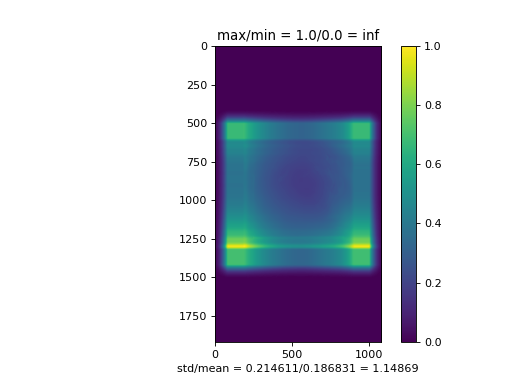

C:\Users\Logan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


In [13]:
import joblib
maskPath = saveDataPath
maskName = "phonemask_blk720x720_antiatt_phone_mask_onsite_lb450_1_1015_233224.bmp.pkl"
mask_str = "onsite"
# maskName = "blk600x600_antiatt_phone_mask_raw_0911_142600.bmp"
# mask_str = "rawmask"
phone_mask = joblib.load(saveDataPath / maskName)
# if len(mask.shape)==3:
#     mask = mask[:,:,1]
phone_mask
im_maxmin(phone_mask)

In [14]:
expan_r = 5
x_norm_expan = torch.repeat_interleave(torch.ones(28, 28), expan_r, dim=0)
x_norm_expan = torch.repeat_interleave(x_norm_expan, expan_r, dim=1)
x_norm_embedded = CenterEmbedding(x_norm_expan, torch.zeros(1920, 1080))
sub_phone_mask = phone_mask * x_norm_embedded.numpy()
sub_phone_mask = sub_phone_mask / sub_phone_mask.max()
plt.figure()
plt.imshow(sub_phone_mask)
plt.show()

NameError: name 'CenterEmbedding' is not defined

# Definition of the Neural Network

In [14]:
""" Define digitized fully connected layers """

# Definition of an in-place digitization function.
def Digitize(tensor, quant_mode='det', levels=16, min_val=None, max_val=None):
    if not min_val and not max_val:
        min_val, max_val = tensor.min().item(), tensor.max().item()
    tensor.clamp_(min_val, max_val).add_(-1*min_val).mul_(levels-1).div_(max_val-min_val)
    if quant_mode == "det": 
        tensor.round_()
    elif quant_mode == "rand":
        tensor.add_(torch.rand(tensor.size(), device=tensor.device).add_(-0.5)).round_()
    tensor.mul_(max_val-min_val).div_(levels-1).add_(min_val)
    return tensor

class DigitizeLinear(nn.Linear):

    def __init__(self,  *kargs, a_quant_mode="det", w_quant_mode="det", a_quant_levels=16, w_quant_levels=32, running_weight=0.001, **kwargs):
        super(DigitizeLinear, self).__init__(*kargs, **kwargs)
        self.act_quant_mode = a_quant_mode
        self.weight_quant_mode = w_quant_mode
        self.register_buffer("act_quant_levels", torch.tensor(a_quant_levels))
        self.register_buffer("weight_quant_levels", torch.tensor(w_quant_levels))
        self.register_buffer("running_weight", torch.tensor(running_weight)) 
        self.register_buffer("running_min", None)
        self.register_buffer("running_max", None)

    def forward(self, input):

        if not self.weight_quant_mode is None: # Set a flag to control weight digitization.
            if not hasattr(self.weight,'org'):
                self.weight.org=self.weight.data.clone()
            self.weight.data=Digitize(self.weight.data, quant_mode=self.weight_quant_mode, levels=self.weight_quant_levels)

        if not self.bias is None:
            self.bias.org=self.bias.data.clone()    
        out = nn.functional.linear(input, self.weight, bias=self.bias)

        if not self.act_quant_mode is None: # A flag to control output digitization. 
            if self.training: # Update the running average of min and max only during training
                with torch.no_grad():
                    if not self.running_min and not self.running_max:
                        self.running_min, self.running_max = out.min(), out.max()
                    self.running_min = (1-self.running_weight) * self.running_min + self.running_weight * out.min()
                    self.running_max = (1-self.running_weight) * self.running_max + self.running_weight * out.max()
            out.data=Digitize(out.data, quant_mode=self.act_quant_mode, levels=self.act_quant_levels, min_val=self.running_min, max_val=self.running_max)
    
        return out

In [15]:
""" Define a generic QAT MLP structure (including perceptron) """

class Net(nn.Module):
    def __init__(self, Nunits, **kwargs):
        super().__init__()
        self.fcs = nn.ModuleList([DigitizeLinear(i,j,**kwargs) for i, j in zip(Nunits[:-1], Nunits[1:])])

    def forward(self, X):
        X = X.view(X.size(0), -1)
        for i, fc in enumerate(self.fcs):
            X = fc(X)
            if fc is not self.fcs[-1]:
                X = F.relu(X)
        return X
    
    def set_digitize_config(self, a_quant_mode, w_quant_mode, a_quant_levels, w_quant_levels):
        for fc in self.fcs:
            fc.act_quant_mode = a_quant_mode
            fc.weight_quant_mode = w_quant_mode
            fc.act_quant_levels = torch.tensor(a_quant_levels)
            fc.weight_quant_levels = torch.tensor(w_quant_levels)

In [16]:
""" Load the trained model """

device = "cpu"

model = Net([784, 100, 100, 10])
for l in model.fcs:
    l.running_min = torch.tensor(0.0)
    l.running_max = torch.tensor(0.0)
model_ckpt = torch.load("./RA_4bit_H2_100_100_lr_0.043_0.50_m_0.87_wep_6_randActDigi_v80_ep97.pt", map_location=device)
model_state_dict = model_ckpt["model_state_dict"]
model.load_state_dict(model_state_dict)
model.to(device)
model.eval()

Net(
  (fcs): ModuleList(
    (0): DigitizeLinear(in_features=784, out_features=100, bias=True)
    (1): DigitizeLinear(in_features=100, out_features=100, bias=True)
    (2): DigitizeLinear(in_features=100, out_features=10, bias=True)
  )
)

In [17]:
""" Construct dataloaders """

trainID_range = range(200) # ID of the samples to be passed through the NN

# Import the test data loaders
kwargs = {'num_workers': 1, 'pin_memory': True} if True else {}

data_mnist_test = datasets.MNIST('../ML_data', 
                                 train=False, 
                                 transform=transforms.Compose([transforms.ToTensor()]))

# Remember to set the batch size to the length of train ID range, or the dataloader will draw sample one by one.
subset_data_loader = torch.utils.data.DataLoader(data_mnist_test, 
                                           batch_size=int(max(trainID_range)+1), 
                                           shuffle=False, **kwargs)

# Remember to set the batch size to the length of train ID range, or the dataloader will draw sample one by one.
test_loader = torch.utils.data.DataLoader(data_mnist_test, 
                                           batch_size=1, 
                                           shuffle=False,  **kwargs)

# Notes on ONN Forward Propagation Implementation (Rev. 3)

The update equation from one neuron layer to the next:

\begin{equation}
x_{i}^{L+1} = \sigma(\sum_{j}^N{W_{ij}^{L} x_{j}^{L}+b_i^{L}})    
\end{equation}

where $x_j^L$ is the activation of neuron $j$ in layer $L=0,1,..$.

Since the pixel values in an ONN are intensity encoded, including inputs, activations, and weights, the update equation needs to be modified such that the matrices and vectors to be loaded onto the ONN contain only non-negative numbers. In fact, the possible range of matrix and vector entries is actually limited to positive values, since the phone and SLM pixel values cannot infinitely approach zero in reality, due to hardware limitations. The following framework deals with the most general case where both phone and SLM pixel values cannot be extinguished to zero. If reality, if the resolution permits, the expression can be significantly simplified if either phone or SLM pixels can reach zero within the demanded accuracy.

The update equation is first rewritten into a vector form to facilitate the following discussion:

\begin{equation}
X^{L+1} = \sigma({W^{L} X^{L} + B^{L}})    
\end{equation}

A note on symbol convention: any lower case letter represents a column vector (e.g., $b$, $x$); any captital letter represents a matrix (e.g., $W$, and $X$ actually indicates a batch of data $X = [x_0, x_1, ..., x_{B-1}]$); columns and rows of a matrix is represented in Python indexing convention (i.e., $W[,j]$ and $W[i,]$); element at row $i$ and column $j$ of matrix $W$ is written as $W[i,j]$ instead of $W_{ij}$; the $i$th element in vector a vector is also indicated with Python indexing convention (e.g., $x[i]$ instead of $x_i$). The superscript $L$ indicating the layer of NN is dropped here and below as long as it does not cause any confusion. 

Therefore, $W^L[i,j]$ is the weight from neuron i in layer L to neuron j in layer L+1, $X^L[j,k]$ is the actication of neuron j of data batch index k, $B^L[i,k]$ is the bias for neuron i in layer L.

Each element in a row $W[i,]$ can be linearly mapped from interval $[\text{min}(W[i,]), \text{max}(W[i,])]$ to $[I_\text{min}, I_\text{max}]$, with $I_\text{max}>I_\text{min} \geq 0$. More explicitely, the resultant matrix $\tilde{W}$ is related to $W$ with the relation:

\begin{equation}
W = \hat{K}\tilde{W} + \hat{D}\mathbb{1}
\end{equation}

where
\begin{equation}
\hat{K}=\frac{1}{I_\text{max}-I_\text{min}}diag\{\Delta W_i = \text{max}(W[i,]) - \text{min}(W[i,])\}, 
\hat{D} = \frac{1}{I_\text{max}-I_\text{min}} diag \{I_\text{max} \text{min}(W[i,]) - I_\text{min} \text{max}(W[i,]) \}
\end{equation}
and $\mathbb{1}$ is all 1 matrix. (Tip: hat implies diagonal matrix; tilde implies the control signal to be sent to a device, such as phone or SLM).


The same transform can be performed on a data batch, which gives $X = \tilde{X} \hat{K}_X  +  \mathbb{1}\hat{D}_X$ ($\hat{K}_X$ and $X$ switch position because the definiation of $X$ is transposed from that of $W$.)

Now we can rewrite the update equation as
\begin{equation}
X^{L+1}  = \sigma( \hat{K}  \{\tilde{W} \tilde{X}^L\} \hat{K}_X  + \hat{D} \{\mathbb{1} \tilde{X}^L\} \hat{K}_X  + \hat{K} \{\tilde{W}\mathbb{1}\}\hat{D}_X + \hat{D} \mathbb{1}\mathbb{1} \hat{D}_X + b)
\end{equation}


Note that the matrix products in curly brackets are to be measured expiermentally from the ONN output, and the other quantities are computed once and stored.


The reason to rewrite the update equation in this form is to carry out *each* inner product computation at the full pixel resolution of the smartphone and SLM. The matrices and vectors are always normalized to cover the entire dynamic range of the devices. The normalization factor is stored and later re-applied to the value readout from the ONN to recover the actual numerical value. 


More specifically, the passing of NN activation from one layer to the next can be summarized as the following steps:
1. Normalize $W$ to $\tilde{W}$, which needs to be done only once for a trained NN and takes $O(MN)$ operations. 
2. Normalize $X$ to $\tilde{X}$, which needs to be done for every input and layer and takes a total of $NBL$ multiplications. However, these operations can be waived if the phone pixel has high enough bit depth. Since the activations are usually non-negative numbers, it is possible to represent them with pixel intensity without any pre-processing.
3. Load $\tilde{X}$ to the phone to control pixel intensity and $\tilde{W}$ to SLM to control transimission. In this way, $\tilde{W}$ and $\tilde{X}$ are both represented with the full resolutin of the devices.
4. Measure the total pixel value in a region of interest that corresponds to the inner product $\tilde{W}[i,]\tilde{X}[,j]$ (read: the input to neuron $i$ for the data batch index $j$) in the captured camera image. In the ideal case, this signal can be measured by a single-pixel detector.
5. Use the calibration model to find $\tilde{W}[i,]\tilde{X}[,j]$ based on the integrated pixel value in the regions of interest, obtained in step (4). 
6. After reading out all the entries of $\tilde{W}\tilde{X}$ (W_til_X_til), multiply it with $\hat{D}$ and $\hat{D_X}$ digitially, which were obtained in step (1) and (2).
7. Derive $\mathbb{1} \tilde{X}$ (sum_X_til) and $\tilde{W}\mathbb{1}$ (sum_W_til) following similar steps as (5) and (6). Essentially they are just special cases of $\tilde{W}\tilde{X}$ with either $\tilde{W} = \mathbb{1}$ or $\tilde{X} = \mathbb{1}$.
8. Add the computed terms $\hat{K}\tilde{W}\tilde{X}\hat{K}_X$ (Delta_W_Delta_X), $\hat{D}\mathbb{1}\tilde{X}\hat{K}_X$ (Offset_W_Delta_X),  $\hat{K}\tilde{W}\mathbb{1}\hat{D}_X$ (Delta_W_Offset_X), $\hat{D} \mathbb{1}\mathbb{1}\hat{D}_X$ (Offset_W_Offset_X), and $b$ digitally, and then apply the nonlinear activation function $\sigma$ to obtain the activations of neurons.



In [18]:
"""Auxilitary functions for simulating activation propation in ONN"""

def digitize(x, levels=8, min_val=None, max_val=None):
    """
    digitize activations into the discrete steps, by rounding to the closest level.
    levels: specifies the number of total discrete levels.
    min_val: the x value to be mapped to the lowest level
    max_val: the x value to be mapped to the highest level
    """

    if not min_val and not max_val:
        min_val, max_val = x.min(), x.max()
    x = (levels-1)*(x - min_val)/(max_val-min_val)
    x = x.round()
    x = torch.min(torch.max(x, torch.zeros_like(x)), torch.ones_like(x)*(levels-1))
    x = x*(max_val-min_val)/(levels-1) + min_val
    return x

def Matrix_Linear_Mapping(W, target_interval):
    """
    Transform each column of W with the following linear transform: 
    Argument target_interval=[a,b] specifies the lower and upper bound a and b.
    The minimum of each column of W will be mapped to a, and the maximum of each W column mapped to b.
    The rest of elements in the column are mapped in-between a and b with linear interporlation.
    Such operation is repeated for each column individually.
    """
    
    W = W.type(torch.double)
    W_mins, _ = torch.min(W, dim=0) 
    W_maxs, _ = torch.max(W, dim=0)
    Delta_I = float(target_interval[1] - target_interval[0])
    Delta_W = W_maxs - W_mins
    K_W = torch.diag(Delta_W/Delta_I)
    D_W = target_interval[1]*W_mins - target_interval[0]*W_maxs
    offset = torch.mm(torch.repeat_interleave(D_W.view(1,-1), W.shape[0],dim=0), torch.diag(1/Delta_W))
    W_til = torch.mm(W, torch.diag(Delta_I/Delta_W)) - offset
    
    return (W_til, K_W, torch.diag(D_W)/Delta_I)
    

def ONN_layer_prop(layer, W_transform, X_transform, W_digitize_func=None, X_digitize_func=None, Act_digitize_func=None,  X=None,
                     W_til_X_til=None, sum_W_til=None, sum_X_til=None):
    """
    Forward propagate a batch of data for one layer.

    layer: of type torch.nn.module, the layer to propagate the current batch of data through. Both W and b are derived from layer.
    W_transform: the mapping from the W stored in layer to the control value to be applied to SLM.
    X_transform: the mapping from the activation values stored in X to the control value to be applied to the smartphone.
    Act_digitize_func: The function for digitizing the output activation. No digitization is performed if None is given.
    W_digitize_func: The function for digitizing weight matrix W before the forward propagation. 
                     No digitization is performed if None is assigned to W_digitize_func as default.
    X_digitize_func: The function for digitizing the batch data X before the forward propagation. 
                     No digitization is performed if None is assigned to X_digitize_func as default.
    X: Inputs to the current NN layer. 
       If X is not given, an identity matrix is assigned to X as default, such that the W_til_X_til returned by the function equals W_til.
       X.shape = [batch size, current NN layer width]
    W: weight matrix derived from layer. W.shape = [current NN layer width, next NN layer size]
    b: bias vector. b.shape = [next NN layer width]
    
    When no digitization is performed on W, X, or Wx+b, only linear stretching is performed on W and X, and the output of the function is 
    almost identical to the results obtained by prop(layer).
    """
    
    W = layer.weight.data.t()
        
    # Normalize W 
    (W_til, K_W, D_W) = W_transform(W)
    
    if X is None: # If X is not given, make it an identity matrix.
        X = torch.eye(W.shape[0])
        (X_til, K_X, D_X) = Matrix_Linear_Mapping(X, [0,1])
    else: # Normalize X
        (X_til, K_X, D_X) = X_transform(X.t())
        (X_til, K_X, D_X) = (X_til.t(), K_X.t(), D_X.t())
    
    if W_digitize_func is not None:
        W_til = W_digitize_func(W_til)
        
    if X_digitize_func is not None:
        X_til = X_digitize_func(X_til)
        
    W_til_max = W_til[:,0].max()
    X_til_max = X_til[0,:].max()
    
    # First simulate the three measurables from the ONN (defined in Notes on ONN Forward Propagation Implementation (Rev. 3)):
    if W_til_X_til is None:
        W_til_X_til = torch.mm(X_til, W_til) # tilde{WX} 
    if sum_X_til is None:
        sum_X_til = torch.mm(X_til, torch.ones_like(W_til)) * W_til_max # sum(tilde{X[j,:]}), aka the sum of all activations of batch index j.   
    if sum_W_til is None:
        sum_W_til = torch.mm(torch.ones_like(X_til), W_til) * X_til_max# sum(tilde{W[:,i]}), aka the sum of all weights into neuron i.
    
    # The following terms are defined in Notes on ONN Forward Propagation Implementation (Rev. 3)
    Delta_W_Delta_X = torch.mm(torch.mm(K_X, W_til_X_til), K_W) 
    Delta_W_Offest_X = torch.mm(torch.mm(K_X, sum_X_til), D_W) / W_til_max
    Offset_W_Delta_X = torch.mm(D_X, torch.mm(sum_W_til, K_W)) / X_til_max
    Offset_W_Offset_X = torch.mm(D_X, torch.mm(torch.ones_like(W_til_X_til)*W_til.shape[0], D_W)) 
    
    Wx = Delta_W_Delta_X + Delta_W_Offest_X + Offset_W_Delta_X + Offset_W_Offset_X  # Wx
    Wx_b = Wx + torch.repeat_interleave(layer.bias.view(1,-1), W_til_X_til.shape[0], dim=0).type(torch.double) # Wx+b
    if Act_digitize_func is not None:
        Wx_b = Act_digitize_func(Wx_b) # digitize(Wx+b)
    a = F.relu(Wx_b) # ReLU(digitize(Wx+b))

    return {"norm(W)norm(X)": W_til_X_til, "sum(norm(X))": sum_X_til, "sum(norm(W))": sum_W_til, "Wx": Wx, "Wx+b": Wx_b, "a": a}

In [19]:
# Calculate the ground truth of activations of each layer 
# by Propagating each test sample through the trained NN and record activation of each layer.
import pandas

X, data_labels = next(iter(subset_data_loader))
X = X.view(X.size(0), -1)
X0 = X

df_layer = {}

# Define the transform and quantization functions for all layers:
W_transform = lambda W: Matrix_Linear_Mapping(W, [5,2**8-1])
X_transform = lambda X: Matrix_Linear_Mapping(X, [0,1000-1])
W_digitize = lambda W: Digitize(W.clone(), levels=2**8-5) # levels of quantization for W
X_digitize = lambda X: Digitize(X.clone(), levels=1000) # levels of quantization for X
# One very strange thing is that you cannot lambda function dictionary

for l, layer in enumerate(model.fcs):
    # Calculate the ground truth activation by passing through one layer
    layer.act_quant_mode=None
    layer.weight_quant_mode=None
    X0 = F.relu(layer(X0))
    
    # Propagate the batch for one layer
    Act_digitize = lambda X: Digitize(X.clone(), levels=2**4, min_val=layer.running_min.item(), max_val=layer.running_max.item()) # levels of quantization for y=Wx+b
    results = ONN_layer_prop(layer, W_transform, X_transform, \
                             W_digitize_func=W_digitize, X_digitize_func=X_digitize, Act_digitize_func=Act_digitize, X=X)    
    X = results["a"] # The activation of the current layer is the input to the next layer. 
    
    results["a_true"] = X0
    df = {}
    for k in results.keys():
        df[k] = pandas.DataFrame(results[k].detach().numpy()).stack(level=-1)
    df_layer[l] = pandas.concat(df, axis=1)
        
# Concatenate the df for each sample into an even larger one to include all the samples spcified.    
df_all_acts = pandas.concat(df_layer, axis=0, \
                            keys=df_layer.keys(), names=["layer", "test_ID", "output node"])
df_all_acts.index = df_all_acts.index.swaplevel(0,1)

In [20]:
df_all_acts

norm(W)norm(X)  sum(norm(X))  sum(norm(W))  \
test_ID layer output node                                               
0       0     0                 7435548.0    18435480.0   101575323.0   
              1                 9019478.0    18435480.0    99886014.0   
              2                 9160499.0    18435480.0    95635269.0   
              3                 9690888.0    18435480.0   101176722.0   
              4                11035015.0    18435480.0    94579326.0   
...                                   ...           ...           ...   
199     2     5                  596998.0     2243745.0    10846143.0   
              6                  604275.0     2243745.0     9649341.0   
              7                 1273638.0     2243745.0    10318671.0   
              8                 1021207.0     2243745.0    12271716.0   
              9                  682060.0     2243745.0    11444544.0   

                                   Wx        Wx+b          a      a_true  
test_ID layer output node                                                 
0       0     0            -15.719175  -15.587848   0.000000    0.000000  
              1             -3.035051   -1.576992   0.000000    0.000000  
              2             -1.905754   -1.576992   0.000000    0.000000  
              3              2.341606    5.428436   5.428436    2.607136  
              4             13.105385   12.433863  12.433863   12.107492  
...                               ...         ...        ...         ...  
199     2     5           -502.093804 -515.057654   0.000000    0.000000  
              6           -495.412649 -515.057654   0.000000    0.000000  
              7            119.142521   94.972668  94.972668  101.693199  
              8           -112.619283 -108.370772   0.000000    0.000000  
              9           -423.996730 -413.385933   0.000000    0.000000  

[42000 rows x 7 columns]

In [21]:
print(data_labels[50])
df_all_acts.loc[(50,0)]

tensor(6)


C:\Users\Logan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  


,norm(W)norm(X),sum(norm(X)),sum(norm(W)),Wx,Wx+b,a,a_true
output node,,,,,,,
0,10328027.0,20142450.0,101575323.0,0.475091,-1.576992,0.000000,0.000000
1,10031575.0,20142450.0,99886014.0,-1.898899,-1.576992,0.000000,0.000000
2,11218257.0,20142450.0,95635269.0,7.604060,5.428436,5.428436,6.597994
3,11818030.0,20142450.0,101176722.0,12.407047,12.433863,12.433863,12.708588
4,9299017.0,20142450.0,94579326.0,-7.765229,-8.582420,0.000000,0.000000
...,...,...,...,...,...,...,...
95,8049976.0,20142450.0,105060834.0,-17.767560,-15.587848,0.000000,0.000000
96,9271061.0,20142450.0,97347555.0,-7.989101,-8.582420,0.000000,0.000000
97,10241632.0,20142450.0,106398495.0,-0.216761,-1.576992,0.000000,0.000000


# Generate Phone and SLM Images

In [24]:
L = 1
if L > 0:
    df_hidden_layers = {}
    for l in range(L):
        df_hidden_layers[l] = pandas.read_hdf((resultPath / f"fc{l}_acts_ID_130_to_200_float_2pcts.h5").as_posix(), f"fc{l}_acts")
    
df_measured_acts = pandas.concat(df_hidden_layers, axis=0, \
                            keys=df_hidden_layers.keys(), names=["layer", "test_ID", "output node"])
df_measured_acts.index = df_measured_acts.index.swaplevel(0,1)
df_measured_acts.loc[130]

fcs.0.sim  ground_truth      fcs.0
layer output node                                    
0     0            -2.323618     -1.576992   0.000000
      1            -8.439739     -8.582420   0.000000
      2            -2.559680     -1.576992   0.000000
      3            -4.687803     -1.576992   0.000000
      4            -0.305664     -1.576992   0.000000
...                      ...           ...        ...
      95          -24.565556    -22.593276   0.000000
      96          -11.417867     -8.582420   0.000000
      97           -7.416481     -8.582420   0.000000
      98           -0.445431     -1.576992   0.000000
      99           10.123972     12.433863  16.756596

[100 rows x 3 columns]

The normalized weight matrix to be applied on the SLM looks like below:


<IPython.core.display.Javascript object>


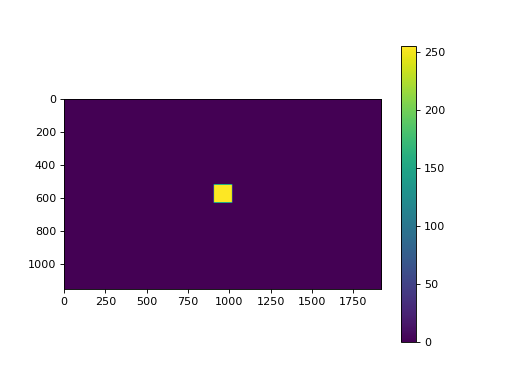

In [25]:
""" Generate the weight images to be applied to SLM and save them. """
# Pre-process the SLM weight matrix by shifting all elements to non-negative.

import numpy as np
from utils.helper_functions import ConvertPhoneImageToSLMImage, NormalizeWeights, CenterEmbedding

# Indicate the current NN layer (the 1st layer has index 0)
expan_r = 9+2

# Convert weight matrix to SLM control values using EXACTLY the same sequence of functions as in ONN_layer_prop()
W = model.fcs[L].weight.data.t()
W_til,_,_ = W_transform(W)
W_norm = W_digitize(W_til).t()
W_norm = W_norm.round().type(torch.uint8)
blkIdx = Wrap_vec_to_square(torch.tensor(df_measured_acts.index.get_level_values(level="output node").unique().values))

slm_weights_numpy = {}

for i in range(W_norm.size(0)):
    # Add a frame for alignment, and embed in a canvas of phone display size
    w_norm_orig = torch.cat((W_norm[i,:],torch.tensor([0])))[blkIdx]
    w_norm_expan = torch.repeat_interleave(w_norm_orig, expan_r, dim=0)
    w_norm_expan = torch.repeat_interleave(w_norm_expan, expan_r, dim=1)
    w_norm_embedded = CenterEmbedding(w_norm_expan, torch.zeros(1920, 1080, dtype=torch.uint8))
    w_norm_slm = ConvertPhoneImageToSLMImage(w_norm_embedded, 1.0) # Convert the phone image to SLM image.

    # Save the SLM patterns to image files.
    w_norm_path = slmWeightPath / (f"SLM_MLP_{expan_r}x_fc{L}_w{i}.bmp")
    w_norm_slm.save(w_norm_path.as_posix(), format = 'bmp') # PIL.Image.save can be saved as 8-bit greyscale bmp
    
w_norm_embedded = CenterEmbedding(torch.ones_like(w_norm_expan)*255, torch.zeros(1920, 1080, dtype=torch.uint8))
w_norm_slm = ConvertPhoneImageToSLMImage(w_norm_embedded, 1.0) # Convert the phone image to SLM image.

# Save the SLM patterns to image files.
w_norm_path = slmWeightPath / (f"SLM_MLP_{expan_r}x_fc{L}_wsum.bmp")
w_norm_slm.save(w_norm_path.as_posix(), format = 'bmp') # PIL.Image.save can be saved as 8-bit greyscale bmp
    
# Plot w_kaleidoscope 
print("The normalized weight matrix to be applied on the SLM looks like below:")
fig, ax = plt.subplots()
im = ax.imshow(w_norm_slm)
fig.colorbar(im, ax=ax)
plt.show()

The normalized weight matrix to be applied on the SLM looks like below:


<IPython.core.display.Javascript object>


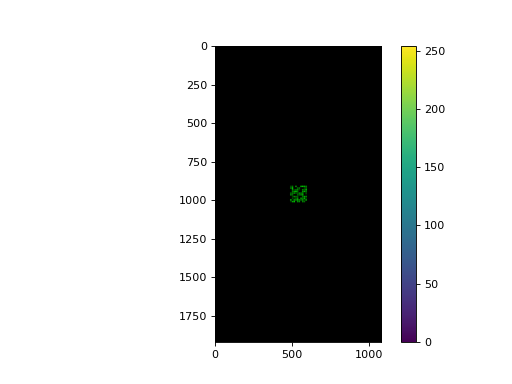

In [26]:
""" Generate the images to be displayed on the phone and save them. """

input_data, data_labels = next(iter(subset_data_loader))
input_data = input_data.view(X.size(0), -1)

subPath = phoneImagePath /  (f"fc{L}_2pcts" )
if not os.path.exists(subPath.as_posix()):
    os.makedirs(subPath.as_posix())

px_margin = 1
blankImage = torch.zeros(3, 1920, 1080, dtype=torch.uint8)

for i, batchIdx in enumerate(range(130, 200)):
    
    # x is the output of the previous layer L-1 (L>0) or the input data (L==0).
    if L > 0:
        x = torch.tensor(df_measured_acts["fcs.0"].loc[batchIdx, L-1, :].values)
        #x = torch.tensor(df_all_acts["a_true"].loc[batchIdx, L-1, :].values) # test mode
    elif L == 0:
        x = input_data[batchIdx,:]
    
    # Normalize each x to its max and min and scale to 7 bit to match the dynamical range of the phone.
    # The operations here are performed EXACTLY the same as in ONN_layer_prop()
    x_til,_,_ = X_transform(x.view(-1,1))
    x_norm = X_digitize(x_til.squeeze()).round().type(torch.long) # round() cannot be omitted for type(torch.long) sometimes work as floor(0)
    
    # Add the singla-pixel frame for image alignment.
    imToPhone = blankImage.clone()
    x_norm_orig = torch.cat((x_norm,torch.tensor([0])))[blkIdx]
    x_norm_expan = torch.repeat_interleave(x_norm_orig, expan_r, dim=0)
    x_norm_expan = torch.repeat_interleave(x_norm_expan, expan_r, dim=1)
    x_norm_spar = x_norm_expan
    x_norm_spar[::expan_r,:] = 0
    x_norm_spar[(expan_r-px_margin)::expan_r,:] = 0
    x_norm_spar[:,::expan_r] = 0
    x_norm_spar[:,(expan_r-px_margin)::expan_r] = 0
    x_norm_embedded = CenterEmbedding(x_norm_spar, blankImage[1,:,:].type(torch.long))
    imToPhone[1, :, :] = lut_p[x_norm_embedded.type(torch.long)] # no uniformness correction
    #phone_corr_numpy = lut_p[(x_norm_embedded * sub_phone_mask).type(torch.long)]
    #imToPhone[1, :, :] = phone_corr_numpy

    # Save the generated image
    imToPhone_PIL = transforms.ToPILImage()(imToPhone)
    imToPhone_PIL.save((subPath / f"test_{expan_r}x_gap2px_MLP_2pcts_fc{L}_digit_{data_labels[batchIdx]}_{batchIdx:05d}.png").as_posix())

# Generate and save a black image to be displayed on the phone for background and power saving.
blackImage_PIL = transforms.ToPILImage()(blankImage)
blackImage_PIL.save((phoneImagePath / "black.png").as_posix())

print("The normalized weight matrix to be applied on the SLM looks like below:")
fig, ax = plt.subplots()
im = ax.imshow(imToPhone_PIL)
fig.colorbar(im, ax=ax)
plt.show()

In [25]:
ConvertPhoneImageToSLMImage(imToPhone[1,:,:], 1.0).save((slmWeightPath / "alignment_check").as_posix(), format = 'bmp')

# Acquire Data

In [27]:
""" Set up MPPC experiment scheme. """

repeats = 100
oscope.set_range(6)
oscope.set_offset(2)
oscope_info(oscope)

{'ID': 'HEWLETT-PACKARD,54845A,US40240103,A.04.50\n',
 'x_range': 0.0001,
 'x_unit': 'SECOND',
 'y_range': 6.0,
 'y_unit': 'VOLT',
 'y_offset': 2.0,
 'y_bounds': [-1.0, 5.0]}

In [28]:
""" Set up the (empty) dataframe table for taking data. """

import pandas

repeats = 50
test_digit_idx = np.arange(40)
node_idx = [*range(100), "sum", "bkg"]
time_ranges = [0.0001, ]
#rowMultiIdx = pandas.MultiIndex.from_product([test_digit_idx, node_idx, time_ranges, np.arange(repeats)], names=["test_ID", "output_node", "time_range", "repeats"])
rowMultiIdx = pandas.MultiIndex.from_product([node_idx, time_ranges, np.arange(repeats)], names=["output_node", "time_range", "repeats"])
#df_volTraces = pandas.DataFrame(index=rowMultiIdx, columns=np.arange(1004))

phoneLoadPath = phoneImagePath / f"fc{L}_2pcts"
slmLoadPath = slmWeightPath 

print(phoneLoadPath)
print(slmLoadPath)
print(rowMultiIdx)
#print(df_volTraces)

D:\McMahon lab Dropbox\peter mcmahon\tw329\Experiments\12_01_20_4bit_randy_aug_MLP_100_100_MPPC\phone_images\fc1_2pcts
D:\McMahon lab Dropbox\peter mcmahon\tw329\Experiments\12_01_20_4bit_randy_aug_MLP_100_100_MPPC\slm_weights
MultiIndex([(    0, 0.0001,  0),
            (    0, 0.0001,  1),
            (    0, 0.0001,  2),
            (    0, 0.0001,  3),
            (    0, 0.0001,  4),
            (    0, 0.0001,  5),
            (    0, 0.0001,  6),
            (    0, 0.0001,  7),
            (    0, 0.0001,  8),
            (    0, 0.0001,  9),
            ...
            ('bkg', 0.0001, 40),
            ('bkg', 0.0001, 41),
            ('bkg', 0.0001, 42),
            ('bkg', 0.0001, 43),
            ('bkg', 0.0001, 44),
            ('bkg', 0.0001, 45),
            ('bkg', 0.0001, 46),
            ('bkg', 0.0001, 47),
            ('bkg', 0.0001, 48),
            ('bkg', 0.0001, 49)],
           names=['output_node', 'time_range', 'repeats'], length=5100)


In [31]:
""" Perform the inference of the trained model with ONN on test digits, and save the data. """

import joblib, pickle, time

exp_time = datetime.now()
savePath = resultPath /  (f"MLP_fc{L}_{expan_r}x_marg_1px_2pcts_MPPC_{exp_time:%m%d_%H%M%S}")
print(savePath)
if not os.path.exists(savePath.as_posix()):
    os.makedirs(savePath.as_posix())

oscope.instrument.write("TIM:RANG 0.0001")

joblib.dump([oscope_info(oscope),], savePath / 'exp_info.pkl')
dataFile = pandas.HDFStore((savePath / "mppc_vol_meas.h5").as_posix())

# write a black image to the phone to take the background
blackImage_PIL = Image.open((phoneImagePath / "black.png").as_posix())
blackImage_byte = PIL_to_bytestream(blackImage_PIL)

for idx in range(170, 200):
#for idx in range(20):
    t0 = time.time()
    # Record background to capture potential voltage bias drift
    aoab.write(blackImage_byte)
    #time.sleep(0.5)
    slmPattern_PIL = Image.open((slmLoadPath / f"SLM_solid_0.bmp").as_posix())
    slm.updateArray((np.array(slmPattern_PIL)).astype('uint8'))
    time.sleep(0.5)
    
    df = pandas.DataFrame(index=rowMultiIdx, columns=np.arange(1004))

    for i in rowMultiIdx.get_level_values("repeats").unique(): 
        trace = oscope.get_waveform()
        df.loc[("bkg", 0.0001, i), range(len(trace))] = trace
        time.sleep(0.04)
    print(f"time_span=0.0001s, test_ID={idx}, label={data_labels[idx]}, output_node=bkg, voltage={trace.mean()}")
        
    # Load the phone pattern
    phonePattern_PIL = Image.open((phoneLoadPath / f"test_{expan_r}x_gap2px_MLP_2pcts_fc{L}_digit_{data_labels[idx]}_{idx:05d}.png").as_posix())
    phonePattern_byte = PIL_to_bytestream(phonePattern_PIL)
    aoab.write(phonePattern_byte)
    time.sleep(0.5) # Wait for the pattern applied to be stable
    for n in rowMultiIdx.get_level_values("output_node").unique().drop("bkg"):
        # refresh the slm pattern
        slmPattern_PIL = Image.open((slmLoadPath / f"SLM_MLP_{expan_r}x_fc{L}_w{n}.bmp").as_posix())
        slm.updateArray((np.array(slmPattern_PIL)).astype('uint8'))
        time.sleep(0.5) # Wait for the pattern applied to be stable
        
        for i in rowMultiIdx.get_level_values("repeats").unique(): 
            trace = oscope.get_waveform()
            df.loc[(n, 0.0001, i), range(len(trace))] = trace
            time.sleep(0.04)
        print(f"time_span=0.0001s, test_ID={idx}, label={data_labels[idx]}, output_node={n}, voltage={trace.mean()}")
            
        if n == 11 and idx == 170:
            print("20 s to exit anydesk")
            time.sleep(20)  
            
    t1 = time.time()
    print(f"Time consumed for 1 sample = {t1-t0} s")
    t0 = t1
    dataFile[str(idx)]=df 
    
dataFile.close()
aoab.write(blackImage_byte)
print("Finished! Safe to change code now.")

D:\McMahon lab Dropbox\peter mcmahon\tw329\Experiments\12_01_20_4bit_randy_aug_MLP_100_100_MPPC\MLP_fc1_11x_marg_1px_2pcts_MPPC_1221_134418


C:\Users\Logan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2878: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


time_span=0.0001s, test_ID=170, label=4, output_node=bkg, voltage=-0.003399402368813753
time_span=0.0001s, test_ID=170, label=4, output_node=0, voltage=0.01005079597234726
time_span=0.0001s, test_ID=170, label=4, output_node=1, voltage=0.01328486017882824
time_span=0.0001s, test_ID=170, label=4, output_node=2, voltage=0.008850596845149994
time_span=0.0001s, test_ID=170, label=4, output_node=3, voltage=0.008786853402853012
time_span=0.0001s, test_ID=170, label=4, output_node=4, voltage=0.004506971687078476
time_span=0.0001s, test_ID=170, label=4, output_node=5, voltage=0.007943226955831051
time_span=0.0001s, test_ID=170, label=4, output_node=6, voltage=0.010580677539110184
time_span=0.0001s, test_ID=170, label=4, output_node=7, voltage=0.010625497438013554
time_span=0.0001s, test_ID=170, label=4, output_node=8, voltage=0.007668327074497938
time_span=0.0001s, test_ID=170, label=4, output_node=9, voltage=0.008696215227246284
time_span=0.0001s, test_ID=170, label=4, output_node=10, voltage

time_span=0.0001s, test_ID=170, label=4, output_node=95, voltage=0.015372510068118572
time_span=0.0001s, test_ID=170, label=4, output_node=96, voltage=0.01223306730389595
time_span=0.0001s, test_ID=170, label=4, output_node=97, voltage=0.005257967859506607
time_span=0.0001s, test_ID=170, label=4, output_node=98, voltage=0.007733067497611046
time_span=0.0001s, test_ID=170, label=4, output_node=99, voltage=0.013783865608274937
time_span=0.0001s, test_ID=170, label=4, output_node=sum, voltage=0.026667330414056778
Time consumed for 1 sample = 642.5427150726318 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '170'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
C:\Users\Logan\Anaconda3\lib\site-packages\pandas\io\pytables.py:556: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->axis1_level0] [items->None]

  self.put(key, value)
C:\Users\Logan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3418: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->floating,key->block0_values] [items->Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
             994,  995,  996,  997,

time_span=0.0001s, test_ID=171, label=7, output_node=bkg, voltage=-0.0038087647408246994
time_span=0.0001s, test_ID=171, label=7, output_node=0, voltage=0.017330676317214966
time_span=0.0001s, test_ID=171, label=7, output_node=1, voltage=0.012082669883966446
time_span=0.0001s, test_ID=171, label=7, output_node=2, voltage=0.007800797000527382
time_span=0.0001s, test_ID=171, label=7, output_node=3, voltage=0.007703186944127083
time_span=0.0001s, test_ID=171, label=7, output_node=4, voltage=0.013669323176145554
time_span=0.0001s, test_ID=171, label=7, output_node=5, voltage=0.008218128234148026
time_span=0.0001s, test_ID=171, label=7, output_node=6, voltage=0.0066583664156496525
time_span=0.0001s, test_ID=171, label=7, output_node=7, voltage=0.011818725615739822
time_span=0.0001s, test_ID=171, label=7, output_node=8, voltage=0.0152370510622859
time_span=0.0001s, test_ID=171, label=7, output_node=9, voltage=0.012012948282063007
time_span=0.0001s, test_ID=171, label=7, output_node=10, volta

time_span=0.0001s, test_ID=171, label=7, output_node=95, voltage=0.012271911837160587
time_span=0.0001s, test_ID=171, label=7, output_node=96, voltage=0.015134462155401707
time_span=0.0001s, test_ID=171, label=7, output_node=97, voltage=0.009549800306558609
time_span=0.0001s, test_ID=171, label=7, output_node=98, voltage=0.01356772892177105
time_span=0.0001s, test_ID=171, label=7, output_node=99, voltage=0.015331672504544258
time_span=0.0001s, test_ID=171, label=7, output_node=sum, voltage=0.03271215409040451
Time consumed for 1 sample = 625.5949375629425 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '171'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=172, label=2, output_node=bkg, voltage=-0.004269920289516449
time_span=0.0001s, test_ID=172, label=2, output_node=0, voltage=0.009460159577429295
time_span=0.0001s, test_ID=172, label=2, output_node=1, voltage=0.009093624539673328
time_span=0.0001s, test_ID=172, label=2, output_node=2, voltage=0.018907371908426285
time_span=0.0001s, test_ID=172, label=2, output_node=3, voltage=0.011152391321957111
time_span=0.0001s, test_ID=172, label=2, output_node=4, voltage=0.016702190041542053
time_span=0.0001s, test_ID=172, label=2, output_node=5, voltage=0.017623506486415863
time_span=0.0001s, test_ID=172, label=2, output_node=6, voltage=0.01776294782757759
time_span=0.0001s, test_ID=172, label=2, output_node=7, voltage=0.0055707176215946674
time_span=0.0001s, test_ID=172, label=2, output_node=8, voltage=0.008940238505601883
time_span=0.0001s, test_ID=172, label=2, output_node=9, voltage=0.013458166271448135
time_span=0.0001s, test_ID=172, label=2, output_node=10, volta

time_span=0.0001s, test_ID=172, label=2, output_node=95, voltage=0.007897410541772842
time_span=0.0001s, test_ID=172, label=2, output_node=96, voltage=0.005906374659389257
time_span=0.0001s, test_ID=172, label=2, output_node=97, voltage=0.016772909089922905
time_span=0.0001s, test_ID=172, label=2, output_node=98, voltage=0.013591633178293705
time_span=0.0001s, test_ID=172, label=2, output_node=99, voltage=0.008452191017568111
time_span=0.0001s, test_ID=172, label=2, output_node=sum, voltage=0.03448307141661644
Time consumed for 1 sample = 626.4017517566681 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '172'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=173, label=3, output_node=bkg, voltage=-0.005169322248548269
time_span=0.0001s, test_ID=173, label=3, output_node=0, voltage=0.008794820867478848
time_span=0.0001s, test_ID=173, label=3, output_node=1, voltage=0.004312749020755291
time_span=0.0001s, test_ID=173, label=3, output_node=2, voltage=0.010720119811594486
time_span=0.0001s, test_ID=173, label=3, output_node=3, voltage=0.008540837094187737
time_span=0.0001s, test_ID=173, label=3, output_node=4, voltage=0.008799800649285316
time_span=0.0001s, test_ID=173, label=3, output_node=5, voltage=0.009125499054789543
time_span=0.0001s, test_ID=173, label=3, output_node=6, voltage=0.008900399319827557
time_span=0.0001s, test_ID=173, label=3, output_node=7, voltage=0.006000996567308903
time_span=0.0001s, test_ID=173, label=3, output_node=8, voltage=0.0020697209984064102
time_span=0.0001s, test_ID=173, label=3, output_node=9, voltage=0.004312749020755291
time_span=0.0001s, test_ID=173, label=3, output_node=10, volt

time_span=0.0001s, test_ID=173, label=3, output_node=95, voltage=0.003617529757320881
time_span=0.0001s, test_ID=173, label=3, output_node=96, voltage=0.010356573387980461
time_span=0.0001s, test_ID=173, label=3, output_node=97, voltage=0.010611552745103836
time_span=0.0001s, test_ID=173, label=3, output_node=98, voltage=0.006140438374131918
time_span=0.0001s, test_ID=173, label=3, output_node=99, voltage=0.009714143350720406
time_span=0.0001s, test_ID=173, label=3, output_node=sum, voltage=0.026760956272482872
Time consumed for 1 sample = 625.0013835430145 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '173'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=174, label=2, output_node=bkg, voltage=-0.005049800965934992
time_span=0.0001s, test_ID=174, label=2, output_node=0, voltage=0.0066533866338431835
time_span=0.0001s, test_ID=174, label=2, output_node=1, voltage=0.006783864460885525
time_span=0.0001s, test_ID=174, label=2, output_node=2, voltage=0.012615538202226162
time_span=0.0001s, test_ID=174, label=2, output_node=3, voltage=0.008738048374652863
time_span=0.0001s, test_ID=174, label=2, output_node=4, voltage=0.020632470026612282
time_span=0.0001s, test_ID=174, label=2, output_node=5, voltage=0.013416334986686707
time_span=0.0001s, test_ID=174, label=2, output_node=6, voltage=0.015367529354989529
time_span=0.0001s, test_ID=174, label=2, output_node=7, voltage=0.004054781049489975
time_span=0.0001s, test_ID=174, label=2, output_node=8, voltage=0.018146412447094917
time_span=0.0001s, test_ID=174, label=2, output_node=9, voltage=0.018093625083565712
time_span=0.0001s, test_ID=174, label=2, output_node=10, volt

time_span=0.0001s, test_ID=174, label=2, output_node=95, voltage=0.01350298710167408
time_span=0.0001s, test_ID=174, label=2, output_node=96, voltage=0.01182470191270113
time_span=0.0001s, test_ID=174, label=2, output_node=97, voltage=0.010452190414071083
time_span=0.0001s, test_ID=174, label=2, output_node=98, voltage=0.017646413296461105
time_span=0.0001s, test_ID=174, label=2, output_node=99, voltage=0.007490039803087711
time_span=0.0001s, test_ID=174, label=2, output_node=sum, voltage=0.03800199180841446
Time consumed for 1 sample = 625.9293675422668 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '174'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=175, label=7, output_node=bkg, voltage=-0.006293824873864651
time_span=0.0001s, test_ID=175, label=7, output_node=0, voltage=0.019269920885562897
time_span=0.0001s, test_ID=175, label=7, output_node=1, voltage=0.01579183340072632
time_span=0.0001s, test_ID=175, label=7, output_node=2, voltage=0.019240040332078934
time_span=0.0001s, test_ID=175, label=7, output_node=3, voltage=0.01644521951675415
time_span=0.0001s, test_ID=175, label=7, output_node=4, voltage=0.021767927333712578
time_span=0.0001s, test_ID=175, label=7, output_node=5, voltage=0.01804482191801071
time_span=0.0001s, test_ID=175, label=7, output_node=6, voltage=0.019369520246982574
time_span=0.0001s, test_ID=175, label=7, output_node=7, voltage=0.02262350544333458
time_span=0.0001s, test_ID=175, label=7, output_node=8, voltage=0.02085059881210327
time_span=0.0001s, test_ID=175, label=7, output_node=9, voltage=0.014828684739768505
time_span=0.0001s, test_ID=175, label=7, output_node=10, voltage=0.

time_span=0.0001s, test_ID=175, label=7, output_node=95, voltage=0.01748804561793804
time_span=0.0001s, test_ID=175, label=7, output_node=96, voltage=0.018211156129837036
time_span=0.0001s, test_ID=175, label=7, output_node=97, voltage=0.01808764971792698
time_span=0.0001s, test_ID=175, label=7, output_node=98, voltage=0.02357769012451172
time_span=0.0001s, test_ID=175, label=7, output_node=99, voltage=0.01531274989247322
time_span=0.0001s, test_ID=175, label=7, output_node=sum, voltage=0.050093624740839005
Time consumed for 1 sample = 628.5884926319122 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '175'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=176, label=1, output_node=bkg, voltage=-0.0026563743595033884
time_span=0.0001s, test_ID=176, label=1, output_node=0, voltage=0.0045717135071754456
time_span=0.0001s, test_ID=176, label=1, output_node=1, voltage=0.004067729227244854
time_span=0.0001s, test_ID=176, label=1, output_node=2, voltage=0.006113545969128609
time_span=0.0001s, test_ID=176, label=1, output_node=3, voltage=0.0011165337637066841
time_span=0.0001s, test_ID=176, label=1, output_node=4, voltage=0.00512848561629653
time_span=0.0001s, test_ID=176, label=1, output_node=5, voltage=0.0017998007824644446
time_span=0.0001s, test_ID=176, label=1, output_node=6, voltage=0.00240239012055099
time_span=0.0001s, test_ID=176, label=1, output_node=7, voltage=0.0039322711527347565
time_span=0.0001s, test_ID=176, label=1, output_node=8, voltage=0.004878486506640911
time_span=0.0001s, test_ID=176, label=1, output_node=9, voltage=0.003736055688932538
time_span=0.0001s, test_ID=176, label=1, output_node=10, vo

time_span=0.0001s, test_ID=176, label=1, output_node=95, voltage=0.01106075756251812
time_span=0.0001s, test_ID=176, label=1, output_node=96, voltage=0.001601593685336411
time_span=0.0001s, test_ID=176, label=1, output_node=97, voltage=0.006414342205971479
time_span=0.0001s, test_ID=176, label=1, output_node=98, voltage=0.0060647414065897465
time_span=0.0001s, test_ID=176, label=1, output_node=99, voltage=0.0042071714997291565
time_span=0.0001s, test_ID=176, label=1, output_node=sum, voltage=0.01804780773818493
Time consumed for 1 sample = 624.0635030269623 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '176'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=177, label=8, output_node=bkg, voltage=-0.00598306767642498
time_span=0.0001s, test_ID=177, label=8, output_node=0, voltage=0.011112549342215061
time_span=0.0001s, test_ID=177, label=8, output_node=1, voltage=0.007689242716878653
time_span=0.0001s, test_ID=177, label=8, output_node=2, voltage=0.00705478060990572
time_span=0.0001s, test_ID=177, label=8, output_node=3, voltage=-0.0005179282161407173
time_span=0.0001s, test_ID=177, label=8, output_node=4, voltage=0.0017808766569942236
time_span=0.0001s, test_ID=177, label=8, output_node=5, voltage=0.007596613373607397
time_span=0.0001s, test_ID=177, label=8, output_node=6, voltage=0.007759960368275642
time_span=0.0001s, test_ID=177, label=8, output_node=7, voltage=0.0033386454451829195
time_span=0.0001s, test_ID=177, label=8, output_node=8, voltage=0.007032868918031454
time_span=0.0001s, test_ID=177, label=8, output_node=9, voltage=0.006600597407668829
time_span=0.0001s, test_ID=177, label=8, output_node=10, vol

time_span=0.0001s, test_ID=177, label=8, output_node=95, voltage=0.003576693357899785
time_span=0.0001s, test_ID=177, label=8, output_node=96, voltage=0.0056952196173369884
time_span=0.0001s, test_ID=177, label=8, output_node=97, voltage=0.004215139430016279
time_span=0.0001s, test_ID=177, label=8, output_node=98, voltage=0.00720816757529974
time_span=0.0001s, test_ID=177, label=8, output_node=99, voltage=0.0038754979614168406
time_span=0.0001s, test_ID=177, label=8, output_node=sum, voltage=0.01784362643957138
Time consumed for 1 sample = 624.2755033969879 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '177'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=178, label=1, output_node=bkg, voltage=-0.004025896079838276
time_span=0.0001s, test_ID=178, label=1, output_node=0, voltage=0.01281573623418808
time_span=0.0001s, test_ID=178, label=1, output_node=1, voltage=0.008461154997348785
time_span=0.0001s, test_ID=178, label=1, output_node=2, voltage=0.012302787974476814
time_span=0.0001s, test_ID=178, label=1, output_node=3, voltage=0.006489044055342674
time_span=0.0001s, test_ID=178, label=1, output_node=4, voltage=0.009961155243217945
time_span=0.0001s, test_ID=178, label=1, output_node=5, voltage=0.012699203565716743
time_span=0.0001s, test_ID=178, label=1, output_node=6, voltage=0.012198206968605518
time_span=0.0001s, test_ID=178, label=1, output_node=7, voltage=0.005522908642888069
time_span=0.0001s, test_ID=178, label=1, output_node=8, voltage=0.009229083545506
time_span=0.0001s, test_ID=178, label=1, output_node=9, voltage=0.008132469840347767
time_span=0.0001s, test_ID=178, label=1, output_node=10, voltage=0

time_span=0.0001s, test_ID=178, label=1, output_node=95, voltage=0.01303386501967907
time_span=0.0001s, test_ID=178, label=1, output_node=96, voltage=0.00820219051092863
time_span=0.0001s, test_ID=178, label=1, output_node=97, voltage=0.00817430391907692
time_span=0.0001s, test_ID=178, label=1, output_node=98, voltage=0.012349601835012436
time_span=0.0001s, test_ID=178, label=1, output_node=99, voltage=0.006140438374131918
time_span=0.0001s, test_ID=178, label=1, output_node=sum, voltage=0.028287848457694054
Time consumed for 1 sample = 625.7654640674591 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '178'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=179, label=8, output_node=bkg, voltage=-0.005910358391702175
time_span=0.0001s, test_ID=179, label=8, output_node=0, voltage=0.0014442228712141514
time_span=0.0001s, test_ID=179, label=8, output_node=1, voltage=0.003065737197175622
time_span=0.0001s, test_ID=179, label=8, output_node=2, voltage=0.0017848605057224631
time_span=0.0001s, test_ID=179, label=8, output_node=3, voltage=-0.00036653393181040883
time_span=0.0001s, test_ID=179, label=8, output_node=4, voltage=9.860567661235109e-05
time_span=0.0001s, test_ID=179, label=8, output_node=5, voltage=0.0065936255268752575
time_span=0.0001s, test_ID=179, label=8, output_node=6, voltage=0.002470119623467326
time_span=0.0001s, test_ID=179, label=8, output_node=7, voltage=-0.0030507969204336405
time_span=0.0001s, test_ID=179, label=8, output_node=8, voltage=0.0033017927780747414
time_span=0.0001s, test_ID=179, label=8, output_node=9, voltage=0.0012758963275700808
time_span=0.0001s, test_ID=179, label=8, output_nod

time_span=0.0001s, test_ID=179, label=8, output_node=94, voltage=0.00032669329084455967
time_span=0.0001s, test_ID=179, label=8, output_node=95, voltage=0.001531872432678938
time_span=0.0001s, test_ID=179, label=8, output_node=96, voltage=-0.000956175266765058
time_span=0.0001s, test_ID=179, label=8, output_node=97, voltage=0.00030378493829630315
time_span=0.0001s, test_ID=179, label=8, output_node=98, voltage=0.0040189241990447044
time_span=0.0001s, test_ID=179, label=8, output_node=99, voltage=0.0007669324986636639
time_span=0.0001s, test_ID=179, label=8, output_node=sum, voltage=0.008410358801484108
Time consumed for 1 sample = 624.4022438526154 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '179'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=180, label=1, output_node=bkg, voltage=-0.005330677609890699
time_span=0.0001s, test_ID=180, label=1, output_node=0, voltage=0.0023665339685976505
time_span=0.0001s, test_ID=180, label=1, output_node=1, voltage=0.0031593625899404287
time_span=0.0001s, test_ID=180, label=1, output_node=2, voltage=0.004900398664176464
time_span=0.0001s, test_ID=180, label=1, output_node=3, voltage=0.0005039840470999479
time_span=0.0001s, test_ID=180, label=1, output_node=4, voltage=0.004766932688653469
time_span=0.0001s, test_ID=180, label=1, output_node=5, voltage=0.0025458165910094976
time_span=0.0001s, test_ID=180, label=1, output_node=6, voltage=0.003327689366415143
time_span=0.0001s, test_ID=180, label=1, output_node=7, voltage=0.004801793023943901
time_span=0.0001s, test_ID=180, label=1, output_node=8, voltage=0.0007709164638072252
time_span=0.0001s, test_ID=180, label=1, output_node=9, voltage=0.001109561650082469
time_span=0.0001s, test_ID=180, label=1, output_node=10, 

time_span=0.0001s, test_ID=180, label=1, output_node=94, voltage=0.0012001991271972656
time_span=0.0001s, test_ID=180, label=1, output_node=95, voltage=0.005132469814270735
time_span=0.0001s, test_ID=180, label=1, output_node=96, voltage=0.0009183267829939723
time_span=0.0001s, test_ID=180, label=1, output_node=97, voltage=0.006280876230448484
time_span=0.0001s, test_ID=180, label=1, output_node=98, voltage=0.006236055865883827
time_span=0.0001s, test_ID=180, label=1, output_node=99, voltage=0.002426294842734933
time_span=0.0001s, test_ID=180, label=1, output_node=sum, voltage=0.013295818120241165
Time consumed for 1 sample = 624.3238091468811 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '180'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=181, label=8, output_node=bkg, voltage=-0.0064163352362811565
time_span=0.0001s, test_ID=181, label=8, output_node=0, voltage=0.007659363094717264
time_span=0.0001s, test_ID=181, label=8, output_node=1, voltage=0.004023904446512461
time_span=0.0001s, test_ID=181, label=8, output_node=2, voltage=0.009185259230434895
time_span=0.0001s, test_ID=181, label=8, output_node=3, voltage=0.0033147407229989767
time_span=0.0001s, test_ID=181, label=8, output_node=4, voltage=0.0031752989161759615
time_span=0.0001s, test_ID=181, label=8, output_node=5, voltage=0.011468127369880676
time_span=0.0001s, test_ID=181, label=8, output_node=6, voltage=0.007974104024469852
time_span=0.0001s, test_ID=181, label=8, output_node=7, voltage=0.0018456177785992622
time_span=0.0001s, test_ID=181, label=8, output_node=8, voltage=0.004679282661527395
time_span=0.0001s, test_ID=181, label=8, output_node=9, voltage=0.007257967721670866
time_span=0.0001s, test_ID=181, label=8, output_node=10, v

time_span=0.0001s, test_ID=181, label=8, output_node=95, voltage=0.005663346499204636
time_span=0.0001s, test_ID=181, label=8, output_node=96, voltage=0.00678585609421134
time_span=0.0001s, test_ID=181, label=8, output_node=97, voltage=0.006210159510374069
time_span=0.0001s, test_ID=181, label=8, output_node=98, voltage=0.00680179288610816
time_span=0.0001s, test_ID=181, label=8, output_node=99, voltage=0.006355577148497105
time_span=0.0001s, test_ID=181, label=8, output_node=sum, voltage=0.022654380649328232
Time consumed for 1 sample = 624.5628709793091 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '181'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=182, label=5, output_node=bkg, voltage=-0.0044442228972911835
time_span=0.0001s, test_ID=182, label=5, output_node=0, voltage=0.013402391225099564
time_span=0.0001s, test_ID=182, label=5, output_node=1, voltage=0.003934262786060572
time_span=0.0001s, test_ID=182, label=5, output_node=2, voltage=0.0037828683853149414
time_span=0.0001s, test_ID=182, label=5, output_node=3, voltage=0.0007021911442279816
time_span=0.0001s, test_ID=182, label=5, output_node=4, voltage=0.002113546011969447
time_span=0.0001s, test_ID=182, label=5, output_node=5, voltage=0.008553784340620041
time_span=0.0001s, test_ID=182, label=5, output_node=6, voltage=0.013320717960596085
time_span=0.0001s, test_ID=182, label=5, output_node=7, voltage=0.003896414302289486
time_span=0.0001s, test_ID=182, label=5, output_node=8, voltage=0.009898406453430653
time_span=0.0001s, test_ID=182, label=5, output_node=9, voltage=0.0047061750665307045
time_span=0.0001s, test_ID=182, label=5, output_node=10, v

time_span=0.0001s, test_ID=182, label=5, output_node=95, voltage=0.004065736662596464
time_span=0.0001s, test_ID=182, label=5, output_node=96, voltage=0.008034860715270042
time_span=0.0001s, test_ID=182, label=5, output_node=97, voltage=0.0036643424537032843
time_span=0.0001s, test_ID=182, label=5, output_node=98, voltage=0.006919322069734335
time_span=0.0001s, test_ID=182, label=5, output_node=99, voltage=0.0052001988515257835
time_span=0.0001s, test_ID=182, label=5, output_node=sum, voltage=0.02343127690255642
Time consumed for 1 sample = 624.8788557052612 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '182'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=183, label=0, output_node=bkg, voltage=-0.003738047555088997
time_span=0.0001s, test_ID=183, label=0, output_node=0, voltage=0.005315736867487431
time_span=0.0001s, test_ID=183, label=0, output_node=1, voltage=0.004865537863224745
time_span=0.0001s, test_ID=183, label=0, output_node=2, voltage=0.00794422347098589
time_span=0.0001s, test_ID=183, label=0, output_node=3, voltage=0.0049332669004797935
time_span=0.0001s, test_ID=183, label=0, output_node=4, voltage=0.004381474107503891
time_span=0.0001s, test_ID=183, label=0, output_node=5, voltage=0.007794820237904787
time_span=0.0001s, test_ID=183, label=0, output_node=6, voltage=0.006806773133575916
time_span=0.0001s, test_ID=183, label=0, output_node=7, voltage=0.0034661355894058943
time_span=0.0001s, test_ID=183, label=0, output_node=8, voltage=0.009118526242673397
time_span=0.0001s, test_ID=183, label=0, output_node=9, voltage=0.008596613071858883
time_span=0.0001s, test_ID=183, label=0, output_node=10, volt

time_span=0.0001s, test_ID=183, label=0, output_node=95, voltage=0.004118525423109531
time_span=0.0001s, test_ID=183, label=0, output_node=96, voltage=0.00596314761787653
time_span=0.0001s, test_ID=183, label=0, output_node=97, voltage=0.0032121515832841396
time_span=0.0001s, test_ID=183, label=0, output_node=98, voltage=0.005029880441725254
time_span=0.0001s, test_ID=183, label=0, output_node=99, voltage=0.004493027459830046
time_span=0.0001s, test_ID=183, label=0, output_node=sum, voltage=0.020273903384804726
Time consumed for 1 sample = 624.3566334247589 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '183'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=184, label=8, output_node=bkg, voltage=-0.005237051751464605
time_span=0.0001s, test_ID=184, label=8, output_node=0, voltage=0.004578685387969017
time_span=0.0001s, test_ID=184, label=8, output_node=1, voltage=0.008129483088850975
time_span=0.0001s, test_ID=184, label=8, output_node=2, voltage=0.013182271271944046
time_span=0.0001s, test_ID=184, label=8, output_node=3, voltage=0.003263944061473012
time_span=0.0001s, test_ID=184, label=8, output_node=4, voltage=0.01147310808300972
time_span=0.0001s, test_ID=184, label=8, output_node=5, voltage=0.012974104844033718
time_span=0.0001s, test_ID=184, label=8, output_node=6, voltage=0.008326693437993526
time_span=0.0001s, test_ID=184, label=8, output_node=7, voltage=0.009015936404466629
time_span=0.0001s, test_ID=184, label=8, output_node=8, voltage=0.005151394288986921
time_span=0.0001s, test_ID=184, label=8, output_node=9, voltage=0.008993026800453663
time_span=0.0001s, test_ID=184, label=8, output_node=10, voltag

time_span=0.0001s, test_ID=184, label=8, output_node=95, voltage=0.010087649337947369
time_span=0.0001s, test_ID=184, label=8, output_node=96, voltage=0.007155378349125385
time_span=0.0001s, test_ID=184, label=8, output_node=97, voltage=0.01169123500585556
time_span=0.0001s, test_ID=184, label=8, output_node=98, voltage=0.0006543825147673488
time_span=0.0001s, test_ID=184, label=8, output_node=99, voltage=0.01512051746249199
time_span=0.0001s, test_ID=184, label=8, output_node=sum, voltage=0.03181872516870499
Time consumed for 1 sample = 622.2333791255951 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '184'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=185, label=9, output_node=bkg, voltage=-0.006102589424699545
time_span=0.0001s, test_ID=185, label=9, output_node=0, voltage=0.0041344622150063515
time_span=0.0001s, test_ID=185, label=9, output_node=1, voltage=0.005355577450245619
time_span=0.0001s, test_ID=185, label=9, output_node=2, voltage=0.0022649401798844337
time_span=0.0001s, test_ID=185, label=9, output_node=3, voltage=0.0024750996381044388
time_span=0.0001s, test_ID=185, label=9, output_node=4, voltage=0.005984063725918531
time_span=0.0001s, test_ID=185, label=9, output_node=5, voltage=0.002386454027146101
time_span=0.0001s, test_ID=185, label=9, output_node=6, voltage=0.0027260954957455397
time_span=0.0001s, test_ID=185, label=9, output_node=7, voltage=0.006391433998942375
time_span=0.0001s, test_ID=185, label=9, output_node=8, voltage=0.0025527889374643564
time_span=0.0001s, test_ID=185, label=9, output_node=9, voltage=0.005948207341134548
time_span=0.0001s, test_ID=185, label=9, output_node=10, 

time_span=0.0001s, test_ID=185, label=9, output_node=95, voltage=0.00850996095687151
time_span=0.0001s, test_ID=185, label=9, output_node=96, voltage=0.004739043768495321
time_span=0.0001s, test_ID=185, label=9, output_node=97, voltage=0.0018386454321444035
time_span=0.0001s, test_ID=185, label=9, output_node=98, voltage=0.0059790839441120625
time_span=0.0001s, test_ID=185, label=9, output_node=99, voltage=0.006259960122406483
time_span=0.0001s, test_ID=185, label=9, output_node=sum, voltage=0.018223106861114502
Time consumed for 1 sample = 624.2364876270294 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '185'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=186, label=2, output_node=bkg, voltage=-0.004178286995738745
time_span=0.0001s, test_ID=186, label=2, output_node=0, voltage=0.010653385892510414
time_span=0.0001s, test_ID=186, label=2, output_node=1, voltage=0.004676294978708029
time_span=0.0001s, test_ID=186, label=2, output_node=2, voltage=0.015117529779672623
time_span=0.0001s, test_ID=186, label=2, output_node=3, voltage=0.010404382832348347
time_span=0.0001s, test_ID=186, label=2, output_node=4, voltage=0.01555677317082882
time_span=0.0001s, test_ID=186, label=2, output_node=5, voltage=0.01241533923894167
time_span=0.0001s, test_ID=186, label=2, output_node=6, voltage=0.013439242728054523
time_span=0.0001s, test_ID=186, label=2, output_node=7, voltage=0.005326693411916494
time_span=0.0001s, test_ID=186, label=2, output_node=8, voltage=0.010747010819613934
time_span=0.0001s, test_ID=186, label=2, output_node=9, voltage=0.013253984041512012
time_span=0.0001s, test_ID=186, label=2, output_node=10, voltage

time_span=0.0001s, test_ID=186, label=2, output_node=95, voltage=0.0034501992631703615
time_span=0.0001s, test_ID=186, label=2, output_node=96, voltage=0.005216136109083891
time_span=0.0001s, test_ID=186, label=2, output_node=97, voltage=0.012083666399121284
time_span=0.0001s, test_ID=186, label=2, output_node=98, voltage=0.010403386317193508
time_span=0.0001s, test_ID=186, label=2, output_node=99, voltage=0.006036852486431599
time_span=0.0001s, test_ID=186, label=2, output_node=sum, voltage=0.031762950122356415
Time consumed for 1 sample = 625.6967051029205 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '186'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=187, label=5, output_node=bkg, voltage=-0.0037499999161809683
time_span=0.0001s, test_ID=187, label=5, output_node=0, voltage=0.011499999091029167
time_span=0.0001s, test_ID=187, label=5, output_node=1, voltage=0.006857569795101881
time_span=0.0001s, test_ID=187, label=5, output_node=2, voltage=0.008406374603509903
time_span=0.0001s, test_ID=187, label=5, output_node=3, voltage=0.006681275088340044
time_span=0.0001s, test_ID=187, label=5, output_node=4, voltage=0.011984063312411308
time_span=0.0001s, test_ID=187, label=5, output_node=5, voltage=0.016377490013837814
time_span=0.0001s, test_ID=187, label=5, output_node=6, voltage=0.013311753049492836
time_span=0.0001s, test_ID=187, label=5, output_node=7, voltage=0.005210159346461296
time_span=0.0001s, test_ID=187, label=5, output_node=8, voltage=0.010043825022876263
time_span=0.0001s, test_ID=187, label=5, output_node=9, voltage=0.006938247010111809
time_span=0.0001s, test_ID=187, label=5, output_node=10, volt

time_span=0.0001s, test_ID=187, label=5, output_node=95, voltage=0.005199202802032232
time_span=0.0001s, test_ID=187, label=5, output_node=96, voltage=0.009623507037758827
time_span=0.0001s, test_ID=187, label=5, output_node=97, voltage=0.0038665339816361666
time_span=0.0001s, test_ID=187, label=5, output_node=98, voltage=0.008905378170311451
time_span=0.0001s, test_ID=187, label=5, output_node=99, voltage=0.008895417675375938
time_span=0.0001s, test_ID=187, label=5, output_node=sum, voltage=0.02326095663011074
Time consumed for 1 sample = 625.6111996173859 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '187'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=188, label=0, output_node=bkg, voltage=-0.0027848605532199144
time_span=0.0001s, test_ID=188, label=0, output_node=0, voltage=0.01024003978818655
time_span=0.0001s, test_ID=188, label=0, output_node=1, voltage=0.013449203222990036
time_span=0.0001s, test_ID=188, label=0, output_node=2, voltage=0.009738048538565636
time_span=0.0001s, test_ID=188, label=0, output_node=3, voltage=0.0064890431240201
time_span=0.0001s, test_ID=188, label=0, output_node=4, voltage=0.013107569888234138
time_span=0.0001s, test_ID=188, label=0, output_node=5, voltage=0.01142430305480957
time_span=0.0001s, test_ID=188, label=0, output_node=6, voltage=0.008928286843001842
time_span=0.0001s, test_ID=188, label=0, output_node=7, voltage=0.01250398438423872
time_span=0.0001s, test_ID=188, label=0, output_node=8, voltage=0.006567729637026787
time_span=0.0001s, test_ID=188, label=0, output_node=9, voltage=0.013539840467274189
time_span=0.0001s, test_ID=188, label=0, output_node=10, voltage=0

time_span=0.0001s, test_ID=188, label=0, output_node=95, voltage=0.009070717729628086
time_span=0.0001s, test_ID=188, label=0, output_node=96, voltage=0.010529881343245506
time_span=0.0001s, test_ID=188, label=0, output_node=97, voltage=0.012800795957446098
time_span=0.0001s, test_ID=188, label=0, output_node=98, voltage=0.005930278450250626
time_span=0.0001s, test_ID=188, label=0, output_node=99, voltage=0.012204183265566826
time_span=0.0001s, test_ID=188, label=0, output_node=sum, voltage=0.029530879110097885
Time consumed for 1 sample = 625.2047350406647 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '188'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=189, label=1, output_node=bkg, voltage=-0.005440238863229752
time_span=0.0001s, test_ID=189, label=1, output_node=0, voltage=0.01866832748055458
time_span=0.0001s, test_ID=189, label=1, output_node=1, voltage=0.012000995688140392
time_span=0.0001s, test_ID=189, label=1, output_node=2, voltage=0.012400397099554539
time_span=0.0001s, test_ID=189, label=1, output_node=3, voltage=0.01046713162213564
time_span=0.0001s, test_ID=189, label=1, output_node=4, voltage=0.01464243046939373
time_span=0.0001s, test_ID=189, label=1, output_node=5, voltage=0.014455179683864117
time_span=0.0001s, test_ID=189, label=1, output_node=6, voltage=0.015451195649802685
time_span=0.0001s, test_ID=189, label=1, output_node=7, voltage=0.00933864526450634
time_span=0.0001s, test_ID=189, label=1, output_node=8, voltage=0.01429183129221201
time_span=0.0001s, test_ID=189, label=1, output_node=9, voltage=0.013955178670585155
time_span=0.0001s, test_ID=189, label=1, output_node=10, voltage=0.

time_span=0.0001s, test_ID=189, label=1, output_node=95, voltage=0.014248007908463478
time_span=0.0001s, test_ID=189, label=1, output_node=96, voltage=0.012653387151658535
time_span=0.0001s, test_ID=189, label=1, output_node=97, voltage=0.008355577476322651
time_span=0.0001s, test_ID=189, label=1, output_node=98, voltage=0.013808765448629856
time_span=0.0001s, test_ID=189, label=1, output_node=99, voltage=0.008474103175103664
time_span=0.0001s, test_ID=189, label=1, output_node=sum, voltage=0.03699402138590813
Time consumed for 1 sample = 624.9476170539856 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '189'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=190, label=1, output_node=bkg, voltage=-0.005422310903668404
time_span=0.0001s, test_ID=190, label=1, output_node=0, voltage=0.018341634422540665
time_span=0.0001s, test_ID=190, label=1, output_node=1, voltage=0.010230079293251038
time_span=0.0001s, test_ID=190, label=1, output_node=2, voltage=0.020368525758385658
time_span=0.0001s, test_ID=190, label=1, output_node=3, voltage=0.0070318724028766155
time_span=0.0001s, test_ID=190, label=1, output_node=4, voltage=0.01902390457689762
time_span=0.0001s, test_ID=190, label=1, output_node=5, voltage=0.01530976127833128
time_span=0.0001s, test_ID=190, label=1, output_node=6, voltage=0.02017330564558506
time_span=0.0001s, test_ID=190, label=1, output_node=7, voltage=0.008855577558279037
time_span=0.0001s, test_ID=190, label=1, output_node=8, voltage=0.016269918531179428
time_span=0.0001s, test_ID=190, label=1, output_node=9, voltage=0.013602589257061481
time_span=0.0001s, test_ID=190, label=1, output_node=10, voltage

time_span=0.0001s, test_ID=190, label=1, output_node=95, voltage=0.021310755982995033
time_span=0.0001s, test_ID=190, label=1, output_node=96, voltage=0.01629183255136013
time_span=0.0001s, test_ID=190, label=1, output_node=97, voltage=0.015322708524763584
time_span=0.0001s, test_ID=190, label=1, output_node=98, voltage=0.01552788820117712
time_span=0.0001s, test_ID=190, label=1, output_node=99, voltage=0.012305776588618755
time_span=0.0001s, test_ID=190, label=1, output_node=sum, voltage=0.042687252163887024
Time consumed for 1 sample = 626.7681727409363 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '190'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=191, label=1, output_node=bkg, voltage=-0.005209163762629032
time_span=0.0001s, test_ID=191, label=1, output_node=0, voltage=0.0035448207054287195
time_span=0.0001s, test_ID=191, label=1, output_node=1, voltage=0.0014272909611463547
time_span=0.0001s, test_ID=191, label=1, output_node=2, voltage=0.006487052422016859
time_span=0.0001s, test_ID=191, label=1, output_node=3, voltage=-0.0008874501218087971
time_span=0.0001s, test_ID=191, label=1, output_node=4, voltage=0.0011235057609155774
time_span=0.0001s, test_ID=191, label=1, output_node=5, voltage=0.007520915940403938
time_span=0.0001s, test_ID=191, label=1, output_node=6, voltage=0.0038635460659861565
time_span=0.0001s, test_ID=191, label=1, output_node=7, voltage=0.0041125500574707985
time_span=0.0001s, test_ID=191, label=1, output_node=8, voltage=0.002315737074241042
time_span=0.0001s, test_ID=191, label=1, output_node=9, voltage=0.003561753313988447
time_span=0.0001s, test_ID=191, label=1, output_node=10

time_span=0.0001s, test_ID=191, label=1, output_node=94, voltage=-0.0005717132589779794
time_span=0.0001s, test_ID=191, label=1, output_node=95, voltage=0.0012818725081160665
time_span=0.0001s, test_ID=191, label=1, output_node=96, voltage=0.0004820717149414122
time_span=0.0001s, test_ID=191, label=1, output_node=97, voltage=0.004494023974984884
time_span=0.0001s, test_ID=191, label=1, output_node=98, voltage=0.0018256971379742026
time_span=0.0001s, test_ID=191, label=1, output_node=99, voltage=0.0019492029678076506
time_span=0.0001s, test_ID=191, label=1, output_node=sum, voltage=0.013252987526357174
Time consumed for 1 sample = 623.8872616291046 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '191'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=192, label=0, output_node=bkg, voltage=-0.0029143427964299917
time_span=0.0001s, test_ID=192, label=0, output_node=0, voltage=0.00817430391907692
time_span=0.0001s, test_ID=192, label=0, output_node=1, voltage=0.005395418033003807
time_span=0.0001s, test_ID=192, label=0, output_node=2, voltage=0.00939143542200327
time_span=0.0001s, test_ID=192, label=0, output_node=3, voltage=0.004431275185197592
time_span=0.0001s, test_ID=192, label=0, output_node=4, voltage=0.004488047212362289
time_span=0.0001s, test_ID=192, label=0, output_node=5, voltage=0.005181274842470884
time_span=0.0001s, test_ID=192, label=0, output_node=6, voltage=0.0065488051623106
time_span=0.0001s, test_ID=192, label=0, output_node=7, voltage=0.0065587651915848255
time_span=0.0001s, test_ID=192, label=0, output_node=8, voltage=0.004060756415128708
time_span=0.0001s, test_ID=192, label=0, output_node=9, voltage=0.012485059909522533
time_span=0.0001s, test_ID=192, label=0, output_node=10, voltage

time_span=0.0001s, test_ID=192, label=0, output_node=95, voltage=0.0065936255268752575
time_span=0.0001s, test_ID=192, label=0, output_node=96, voltage=0.005016931798309088
time_span=0.0001s, test_ID=192, label=0, output_node=97, voltage=0.004368525929749012
time_span=0.0001s, test_ID=192, label=0, output_node=98, voltage=0.008790836669504642
time_span=0.0001s, test_ID=192, label=0, output_node=99, voltage=0.005235059652477503
time_span=0.0001s, test_ID=192, label=0, output_node=sum, voltage=0.023112552240490913
Time consumed for 1 sample = 624.0467610359192 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '192'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=193, label=9, output_node=bkg, voltage=-0.005460159387439489
time_span=0.0001s, test_ID=193, label=9, output_node=0, voltage=0.013395417481660843
time_span=0.0001s, test_ID=193, label=9, output_node=1, voltage=0.006880478002130985
time_span=0.0001s, test_ID=193, label=9, output_node=2, voltage=0.01024003978818655
time_span=0.0001s, test_ID=193, label=9, output_node=3, voltage=0.013390438631176949
time_span=0.0001s, test_ID=193, label=9, output_node=4, voltage=0.012340637855231762
time_span=0.0001s, test_ID=193, label=9, output_node=5, voltage=0.010153386741876602
time_span=0.0001s, test_ID=193, label=9, output_node=6, voltage=0.015142430551350117
time_span=0.0001s, test_ID=193, label=9, output_node=7, voltage=0.008907370269298553
time_span=0.0001s, test_ID=193, label=9, output_node=8, voltage=0.012340637855231762
time_span=0.0001s, test_ID=193, label=9, output_node=9, voltage=0.007626494392752647
time_span=0.0001s, test_ID=193, label=9, output_node=10, voltag

time_span=0.0001s, test_ID=193, label=9, output_node=95, voltage=0.011976095847785473
time_span=0.0001s, test_ID=193, label=9, output_node=96, voltage=0.021759960800409317
time_span=0.0001s, test_ID=193, label=9, output_node=97, voltage=0.0047231074422597885
time_span=0.0001s, test_ID=193, label=9, output_node=98, voltage=0.004815737251192331
time_span=0.0001s, test_ID=193, label=9, output_node=99, voltage=0.011016933247447014
time_span=0.0001s, test_ID=193, label=9, output_node=sum, voltage=0.030075697228312492
Time consumed for 1 sample = 625.0321803092957 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '193'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=194, label=0, output_node=bkg, voltage=-0.005109562072902918
time_span=0.0001s, test_ID=194, label=0, output_node=0, voltage=0.023264940828084946
time_span=0.0001s, test_ID=194, label=0, output_node=1, voltage=0.01843525841832161
time_span=0.0001s, test_ID=194, label=0, output_node=2, voltage=0.027526892721652985
time_span=0.0001s, test_ID=194, label=0, output_node=3, voltage=0.014588646590709686
time_span=0.0001s, test_ID=194, label=0, output_node=4, voltage=0.014730080030858517
time_span=0.0001s, test_ID=194, label=0, output_node=5, voltage=0.024258965626358986
time_span=0.0001s, test_ID=194, label=0, output_node=6, voltage=0.023991037160158157
time_span=0.0001s, test_ID=194, label=0, output_node=7, voltage=0.02316334657371044
time_span=0.0001s, test_ID=194, label=0, output_node=8, voltage=0.021795816719532013
time_span=0.0001s, test_ID=194, label=0, output_node=9, voltage=0.016189243644475937
time_span=0.0001s, test_ID=194, label=0, output_node=10, voltage

time_span=0.0001s, test_ID=194, label=0, output_node=95, voltage=0.021342629566788673
time_span=0.0001s, test_ID=194, label=0, output_node=96, voltage=0.018940238282084465
time_span=0.0001s, test_ID=194, label=0, output_node=97, voltage=0.024051792919635773
time_span=0.0001s, test_ID=194, label=0, output_node=98, voltage=0.01608964055776596
time_span=0.0001s, test_ID=194, label=0, output_node=99, voltage=0.025577690452337265
time_span=0.0001s, test_ID=194, label=0, output_node=sum, voltage=0.05790338292717934
Time consumed for 1 sample = 629.7298924922943 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '194'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=195, label=3, output_node=bkg, voltage=-0.004971115849912167
time_span=0.0001s, test_ID=195, label=3, output_node=0, voltage=0.006182270590215921
time_span=0.0001s, test_ID=195, label=3, output_node=1, voltage=0.0007250996422953904
time_span=0.0001s, test_ID=195, label=3, output_node=2, voltage=0.007852589711546898
time_span=0.0001s, test_ID=195, label=3, output_node=3, voltage=0.002423306927084923
time_span=0.0001s, test_ID=195, label=3, output_node=4, voltage=0.005725099705159664
time_span=0.0001s, test_ID=195, label=3, output_node=5, voltage=0.005596613977104425
time_span=0.0001s, test_ID=195, label=3, output_node=6, voltage=0.0019352590898051858
time_span=0.0001s, test_ID=195, label=3, output_node=7, voltage=2.5896437364281155e-05
time_span=0.0001s, test_ID=195, label=3, output_node=8, voltage=0.0025906371884047985
time_span=0.0001s, test_ID=195, label=3, output_node=9, voltage=0.0019442233024165034
time_span=0.0001s, test_ID=195, label=3, output_node=10,

time_span=0.0001s, test_ID=195, label=3, output_node=94, voltage=0.0008625497575849295
time_span=0.0001s, test_ID=195, label=3, output_node=95, voltage=-0.0018615537555888295
time_span=0.0001s, test_ID=195, label=3, output_node=96, voltage=0.0009671314619481564
time_span=0.0001s, test_ID=195, label=3, output_node=97, voltage=-0.0006075695855543017
time_span=0.0001s, test_ID=195, label=3, output_node=98, voltage=0.0011882471153512597
time_span=0.0001s, test_ID=195, label=3, output_node=99, voltage=0.0005089641781523824
time_span=0.0001s, test_ID=195, label=3, output_node=sum, voltage=0.010706175118684769
Time consumed for 1 sample = 625.1107811927795 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '195'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=196, label=1, output_node=bkg, voltage=-0.003730079857632518
time_span=0.0001s, test_ID=196, label=1, output_node=0, voltage=0.006988047622144222
time_span=0.0001s, test_ID=196, label=1, output_node=1, voltage=0.012644422240555286
time_span=0.0001s, test_ID=196, label=1, output_node=2, voltage=0.0055448212660849094
time_span=0.0001s, test_ID=196, label=1, output_node=3, voltage=0.005519920494407415
time_span=0.0001s, test_ID=196, label=1, output_node=4, voltage=0.003015936352312565
time_span=0.0001s, test_ID=196, label=1, output_node=5, voltage=0.00560358539223671
time_span=0.0001s, test_ID=196, label=1, output_node=6, voltage=0.007257967721670866
time_span=0.0001s, test_ID=196, label=1, output_node=7, voltage=0.0032808766700327396
time_span=0.0001s, test_ID=196, label=1, output_node=8, voltage=0.0063874502666294575
time_span=0.0001s, test_ID=196, label=1, output_node=9, voltage=0.00711454264819622
time_span=0.0001s, test_ID=196, label=1, output_node=10, volt

time_span=0.0001s, test_ID=196, label=1, output_node=95, voltage=0.014046812430024147
time_span=0.0001s, test_ID=196, label=1, output_node=96, voltage=0.009836654178798199
time_span=0.0001s, test_ID=196, label=1, output_node=97, voltage=0.007157370448112488
time_span=0.0001s, test_ID=196, label=1, output_node=98, voltage=0.008349602110683918
time_span=0.0001s, test_ID=196, label=1, output_node=99, voltage=0.005976095795631409
time_span=0.0001s, test_ID=196, label=1, output_node=sum, voltage=0.02557270973920822
Time consumed for 1 sample = 625.1571102142334 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '196'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=197, label=6, output_node=bkg, voltage=-0.007271912414580584
time_span=0.0001s, test_ID=197, label=6, output_node=0, voltage=0.006547808647155762
time_span=0.0001s, test_ID=197, label=6, output_node=1, voltage=0.013249004259705544
time_span=0.0001s, test_ID=197, label=6, output_node=2, voltage=0.012923306785523891
time_span=0.0001s, test_ID=197, label=6, output_node=3, voltage=0.005179282743483782
time_span=0.0001s, test_ID=197, label=6, output_node=4, voltage=0.011773904785513878
time_span=0.0001s, test_ID=197, label=6, output_node=5, voltage=0.017254982143640518
time_span=0.0001s, test_ID=197, label=6, output_node=6, voltage=0.01993725076317787
time_span=0.0001s, test_ID=197, label=6, output_node=7, voltage=0.0037749004550278187
time_span=0.0001s, test_ID=197, label=6, output_node=8, voltage=0.007940239273011684
time_span=0.0001s, test_ID=197, label=6, output_node=9, voltage=0.008575696498155594
time_span=0.0001s, test_ID=197, label=6, output_node=10, volta

time_span=0.0001s, test_ID=197, label=6, output_node=95, voltage=0.011313743889331818
time_span=0.0001s, test_ID=197, label=6, output_node=96, voltage=0.008462151512503624
time_span=0.0001s, test_ID=197, label=6, output_node=97, voltage=0.006037849001586437
time_span=0.0001s, test_ID=197, label=6, output_node=98, voltage=0.00965836737304926
time_span=0.0001s, test_ID=197, label=6, output_node=99, voltage=0.0031354581005871296
time_span=0.0001s, test_ID=197, label=6, output_node=sum, voltage=0.02812948264181614
Time consumed for 1 sample = 625.0127325057983 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '197'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=198, label=4, output_node=bkg, voltage=-0.005246016196906567
time_span=0.0001s, test_ID=198, label=4, output_node=0, voltage=0.023278886452317238
time_span=0.0001s, test_ID=198, label=4, output_node=1, voltage=0.023574700579047203
time_span=0.0001s, test_ID=198, label=4, output_node=2, voltage=0.018057769164443016
time_span=0.0001s, test_ID=198, label=4, output_node=3, voltage=0.015258966013789177
time_span=0.0001s, test_ID=198, label=4, output_node=4, voltage=0.01343824714422226
time_span=0.0001s, test_ID=198, label=4, output_node=5, voltage=0.020442230626940727
time_span=0.0001s, test_ID=198, label=4, output_node=6, voltage=0.019465139135718346
time_span=0.0001s, test_ID=198, label=4, output_node=7, voltage=0.02159561775624752
time_span=0.0001s, test_ID=198, label=4, output_node=8, voltage=0.01948506012558937
time_span=0.0001s, test_ID=198, label=4, output_node=9, voltage=0.011081674136221409
time_span=0.0001s, test_ID=198, label=4, output_node=10, voltage=

time_span=0.0001s, test_ID=198, label=4, output_node=95, voltage=0.03173306584358215
time_span=0.0001s, test_ID=198, label=4, output_node=96, voltage=0.025796812027692795
time_span=0.0001s, test_ID=198, label=4, output_node=97, voltage=0.011350597254931927
time_span=0.0001s, test_ID=198, label=4, output_node=98, voltage=0.01937350630760193
time_span=0.0001s, test_ID=198, label=4, output_node=99, voltage=0.02110259048640728
time_span=0.0001s, test_ID=198, label=4, output_node=sum, voltage=0.048226095736026764
Time consumed for 1 sample = 628.3138289451599 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '198'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=199, label=2, output_node=bkg, voltage=-0.004962151870131493
time_span=0.0001s, test_ID=199, label=2, output_node=0, voltage=0.025384461507201195
time_span=0.0001s, test_ID=199, label=2, output_node=1, voltage=0.017056772485375404
time_span=0.0001s, test_ID=199, label=2, output_node=2, voltage=0.026743028312921524
time_span=0.0001s, test_ID=199, label=2, output_node=3, voltage=0.014409362338483334
time_span=0.0001s, test_ID=199, label=2, output_node=4, voltage=0.030002988874912262
time_span=0.0001s, test_ID=199, label=2, output_node=5, voltage=0.028739044442772865
time_span=0.0001s, test_ID=199, label=2, output_node=6, voltage=0.0260358564555645
time_span=0.0001s, test_ID=199, label=2, output_node=7, voltage=0.023720117285847664
time_span=0.0001s, test_ID=199, label=2, output_node=8, voltage=0.033751994371414185
time_span=0.0001s, test_ID=199, label=2, output_node=9, voltage=0.03199202939867973
time_span=0.0001s, test_ID=199, label=2, output_node=10, voltage=

time_span=0.0001s, test_ID=199, label=2, output_node=95, voltage=0.023452190682291985
time_span=0.0001s, test_ID=199, label=2, output_node=96, voltage=0.022206176072359085
time_span=0.0001s, test_ID=199, label=2, output_node=97, voltage=0.02476493827998638
time_span=0.0001s, test_ID=199, label=2, output_node=98, voltage=0.02698804810643196
time_span=0.0001s, test_ID=199, label=2, output_node=99, voltage=0.027816735208034515
time_span=0.0001s, test_ID=199, label=2, output_node=sum, voltage=0.06931672990322113
Time consumed for 1 sample = 631.4060275554657 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '199'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Finished! Safe to change code now.


In [32]:
df

0      1      2      3      4      5     \
output_node time_range repeats                                             
0           0.0001     0        0.009 -0.005 -0.022 -0.011  0.015  0.129   
                       1       -0.007 -0.004 -0.005  0.007  0.021  0.019   
                       2        0.026  0.017  0.017  0.017  0.017  0.032   
                       3        0.025  0.023  0.012 -0.004  0.001  0.011   
                       4         0.03  0.033  0.028  0.025  0.025  0.024   
...                               ...    ...    ...    ...    ...    ...   
bkg         0.0001     45      -0.007 -0.006 -0.004 -0.003 -0.007 -0.011   
                       46      -0.014 -0.008 -0.006 -0.014 -0.024 -0.024   
                       47       -0.01 -0.005  0.005  0.009  0.009  0.005   
                       48        0.01  0.003 -0.016  -0.03 -0.037 -0.026   
                       49      -0.002  0.004  0.006  0.005      0 -0.013   

                                 6      7      8      9     ...   994    995   \
output_node time_range repeats                              ...                 
0           0.0001     0        0.047  0.041  0.016  0.016  ...  0.035  0.036   
                       1        0.022  0.018  0.009  0.013  ...  0.036  0.009   
                       2        0.032   0.04  0.053  0.057  ...  0.028  0.044   
                       3        0.012  0.015  0.016  0.014  ... -0.001 -0.005   
                       4         0.02  0.027  0.024  0.016  ...  0.027  0.018   
...                               ...    ...    ...    ...  ...    ...    ...   
bkg         0.0001     45       -0.01 -0.005  0.005  0.015  ... -0.005 -0.006   
                       46      -0.025 -0.016 -0.007  0.003  ... -0.029 -0.019   
                       47       0.001 -0.005 -0.013 -0.021  ... -0.005 -0.005   
                       48      -0.006  0.011  0.016  0.008  ... -0.023 -0.029   
                       49      -0.024 -0.026 -0.024 -0.016  ... -0.007 -0.001   

                                 996    997    998    999    1000   1001  \
output_node time_range repeats                                             
0           0.0001     0        0.041  0.036  0.029  0.014  0.018  0.032   
                       1       -0.012 -0.016  -0.01  0.007  0.026  0.033   
                       2        0.121  0.016  0.036  0.027  0.037  0.039   
                       3        0.002  0.007  0.007  0.009 -0.002 -0.013   
                       4        0.011  0.015  0.016  0.016  0.033  0.051   
...                               ...    ...    ...    ...    ...    ...   
bkg         0.0001     45      -0.006  -0.01 -0.011 -0.012 -0.009 -0.004   
                       46       0.003  0.014  0.016  0.011  0.002  0.002   
                       47      -0.003 -0.004 -0.004  0.006   0.01  0.006   
                       48      -0.034  -0.02 -0.007 -0.005 -0.012 -0.019   
                       49       0.001 -0.001 -0.007 -0.011 -0.014 -0.013   

                                 1002   1003  
output_node time_range repeats                
0           0.0001     0        0.039  0.051  
                       1        0.035  0.032  
                       2        0.046  0.052  
                       3       -0.012 -0.001  
                       4        0.107  0.069  
...                               ...    ...  
bkg         0.0001     45      -0.005 -0.005  
                       46       0.004  0.006  
                       47       0.005 -0.001  
                       48      -0.025 -0.018  
                       49      -0.011 -0.005  

[5100 rows x 1004 columns]

In [59]:
df_volTraces.loc[0,].dropna(axis="columns").astype(float).mean(level=[0,1]).mean(axis=1)*100

output_node  time_range
0            0.0001        1.108908
1            0.0001        0.135558
2            0.0001        0.954472
3            0.0001        1.069739
4            0.0001        0.617894
5            0.0001        0.339468
6            0.0001        0.495554
7            0.0001        1.219645
8            0.0001        0.718153
9            0.0001        0.582032
dtype: float64

In [56]:
df_all_acts.loc[0,0]

,norm(W)norm(X),sum(norm(X)),sum(norm(W)),Wx,Wx+b,a,a_true
output node,,,,,,,
0,12298065.0,18435480.0,131674194.0,0.956051,-0.552092,0.000000,0.453606
1,5819807.0,18435480.0,79005915.0,-10.673519,-10.590518,0.000000,0.000000
2,11277890.0,18435480.0,122052825.0,1.561747,1.957514,1.957514,1.641961
3,11975186.0,18435480.0,117449433.0,5.828900,4.467121,4.467121,5.462904
4,9023111.0,18435480.0,101583315.0,-3.535693,-3.061699,0.000000,0.000000
5,7405579.0,18435480.0,84927987.0,-1.884187,-0.552092,0.000000,0.000000
6,8327609.0,18435480.0,110240649.0,-8.759407,-8.080911,0.000000,0.000000
7,13082552.0,18435480.0,119804076.0,11.431123,11.995940,11.995940,12.365005
8,9697962.0,18435480.0,102857040.0,1.703591,-0.552092,0.000000,0.000000


In [28]:
df_volTraces.to_hdf((savePath / "mppc_vol_meas.h5").as_posix(), key=" ", mode='w')
joblib.dump([oscope_info(oscope),], savePath / 'exp_info.pkl')

NameError: name 'df_volTraces' is not defined

In [29]:
blackImage_PIL = Image.open((phoneImagePath / "black.png").as_posix())
blackImage_byte = PIL_to_bytestream(blackImage_PIL)
aoab.write(blackImage_byte)

# Troubleshoot Blocks

In [20]:
# Debug alignment 
from PIL import Image
testImagePath = phoneImagePath / f"test_digit_7_00000.png"
imToPhone_PIL = Image.open(testImagePath)
imToPhone_byte = PIL_to_bytestream(imToPhone_PIL)
slm.updateArray(slm_weights_numpy["ordered"])
aoab.write(imToPhone_byte)

In [37]:
# Debug alignment 
from PIL import Image
alignImagePath = resultPath.parent / "alignment_images" 
imToPhone_PIL = Image.open((alignImagePath / "TheGreenViewFinder.png").as_posix())
imToPhone_byte = PIL_to_bytestream(imToPhone_PIL)
aoab.write(imToPhone_byte)
imToSLM = Image.open((alignImagePath / "TheGreenViewFinder_SLM.bmp").as_posix())
slm.updateArray(np.array(imToSLM))

In [38]:
# Debug alignment 
from PIL import Image
alignImagePath = resultPath.parent / "alignment_images" 
imToPhone_PIL = Image.open((alignImagePath / "Horizontal_stripes_period_4.png").as_posix())
imToPhone_byte = PIL_to_bytestream(imToPhone_PIL)
aoab.write(imToPhone_byte)
imToSLM = Image.open((alignImagePath / "Horizontal_stripes_period_4_SLM.bmp").as_posix())
slm.updateArray(np.array(imToSLM))

In [30]:
# Debug alignment 
from PIL import Image
alignImagePath = resultPath.parent / "alignment_images" 
imToPhone_PIL = Image.open((alignImagePath / "Vertical_stripes_period_4.png").as_posix())
imToPhone_byte = PIL_to_bytestream(imToPhone_PIL)
aoab.write(imToPhone_byte)
imToSLM = Image.open((alignImagePath / "Vertical_stripes_period_4_SLM.bmp").as_posix())
slm.updateArray(np.array(imToSLM))